Rastrigin synthetic function:

GP CBM versus GP dCBM (winner)

https://www.sfu.ca/~ssurjano/rastr.html

In [1]:
pip install pyGPGO


  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 8.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 872.2/872.2 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 12.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.8/16.8 MB 31.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 15.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of arviz to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 38.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 51.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 36.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 1

In [2]:
!pip install -q latextable


In [3]:
### Import modules:

import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import random
import warnings
import itertools

from pyGPGO.logger import EventLogger
from pyGPGO.GPGO import GPGO
from pyGPGO.surrogates.GaussianProcess import GaussianProcess
from pyGPGO.surrogates.tStudentProcess import tStudentProcess, logpdf
from pyGPGO.acquisition import Acquisition
from pyGPGO.covfunc import squaredExponential

from collections import OrderedDict
from joblib import Parallel, delayed
from numpy.linalg import slogdet, inv, cholesky, solve
from scipy.optimize import minimize
from scipy.spatial.distance import cdist
from scipy.special import gamma
from scipy.stats import norm, t
from matplotlib.pyplot import rc
rc('text', usetex=False)

from tabulate import tabulate
from texttable import Texttable

import latextable

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=UserWarning)


/usr/local/lib/python3.10/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
### Inputs:

obj_func = 'Rastrigin'
n_test = 500 # test points
eps = 1e-08
df = 3 # nu

util = 'CBM'
n_init = 5 # random initialisations

cov_func = squaredExponential()
hyperOpt = True


In [5]:
### Objective function:

if obj_func == 'Rastrigin':

    # True y bounds:
    y_lb = 0
    operator = -1 # targets global minimum
    y_global_orig = y_lb * operator # targets global minimum

# Constraints:
    lb = -5.12
    ub = +5.12

# Input array dimension(s):
    dim = 2

# 2-D inputs' parameter bounds:
    param = {'x1_training': ('cont', [lb, ub]),
             'x2_training': ('cont', [lb, ub])}

# Test data:
    x1_test = np.linspace(lb, ub, n_test)
    x2_test = np.linspace(lb, ub, n_test)
    Xstar_d = np.column_stack((x1_test, x2_test))

    def f_syn_polarity(x1_training, x2_training):
        return operator * (10 * dim + x1_training** 2 - 10 * np.cos(2 * np.pi * x1_training)
                                    + x2_training** 2 - 10 * np.cos(2 * np.pi * x2_training)
                          )


In [6]:
max_iter = dim * 10  # iterations of Bayesian optimisation
Beta_CBM = dim


In [7]:
### Cumulative Regret Calculator:

def min_array(x):
    new_list = []
    for i, num in enumerate(x):
            new_list.append(np.min(x[0:i+1]))
    return new_list


In [8]:
### Set-seeds:

run_num_1 = 1
run_num_2 = 2
run_num_3 = 3
run_num_4 = 4
run_num_5 = 5
run_num_6 = 6
run_num_7 = 7
run_num_8 = 8
run_num_9 = 9
run_num_10 = 10
run_num_11 = 11
run_num_12 = 12
run_num_13 = 13
run_num_14 = 14
run_num_15 = 15
run_num_16 = 16
run_num_17 = 17
run_num_18 = 18
run_num_19 = 19
run_num_20 = 20


In [9]:
### Surrogate derivatives:

def kronDelta(X, Xstar):                     # Kronecker's Delta method
    return cdist(X, Xstar) < np.finfo(np.float32).eps

def se(X, Xstar, sigmaf, l, sigman):         # S.E. kernel method
    return sigmaf * np.exp(-0.5 * cdist(X, Xstar) ** 2 / l ** 2) + sigman * kronDelta(X, Xstar)

def delta(X, Xstar):                         # Distance between training X and test Xstar vectors
    return (X - Xstar)

def der_covmat(X, Xstar, sigmaf, l, sigman): # Covariance matrix derivative terms (i.e. exact, first-order)
    nx = len(X)
    ny = len(Xstar)
    return np.round(np.array([(delta(np.atleast_2d(i), np.atleast_2d(j))[0] * se(np.atleast_2d(i), np.atleast_2d(j), sigmaf, l, sigman)[0]).sum() for (i, j) in itertools.product(X, Xstar)]).reshape(nx, ny), 8)

class dGaussianProcess(GaussianProcess):    # Via inheritance, also optimises hyperparameters when opt = TRUE

    def AcqGrad(self, Xstar):               # Method returning exact, first-order derivatives of the GP's posterior mean and standard deviation
        Xstar = np.atleast_2d(Xstar)
        Kstar = self.covfunc.K(self.X, Xstar).T

        dKstar = der_covmat(self.X, Xstar, self.covfunc.sigmaf, self.covfunc.l, self.covfunc.sigman).T
        alpha_Kstar = np.dot(np.linalg.inv(self.K + (self.covfunc.sigman**2) * np.eye(len(self.X))), Kstar.T)

        dm = np.dot(dKstar, self.alpha)
        ds = -2 * np.diag(np.dot(dKstar, alpha_Kstar))

        return dm, ds


In [10]:
### Add exact acquisition function gradient as attribute:

class Acquisition_grad(Acquisition):
    def __init__(self, mode, eps=eps, **params):

        self.params = params
        self.eps = eps

        mode_dict = {
            'CBM': self.CBM
        }

        self.f = mode_dict[mode]

    def CBM(self, y_global_orig, mean, std, ds, dm):
        gamma = (mean - y_global_orig - self.eps) / (std + self.eps)
        dsdx = ds / (2 * (std + self.eps))
        dmdx = (dm - gamma * dsdx) / (std + self.eps)

        f = (std + self.eps) * (gamma + np.sqrt(Beta_CBM))
        df = dsdx * (gamma + np.sqrt(Beta_CBM)) + (std + self.eps) * dmdx
        df_arr = []

        for j in range(0, dim):
          df_arr.append(df)
        return f, np.asarray(df_arr).transpose()

    def d_eval(self, tau, mean, std, ds, dm):

        return self.f(tau, mean, std, ds, dm, **self.params)


In [11]:
n_start_AcqFunc = 20
inverse = -1
n_start = n_start_AcqFunc

maxfunMinimize = 50 * dim # allows for both function and gradient evaluation capping, using the problem's input dimensions


In [12]:
## GPGO_approx: BayesOpt class, acquision function optimised using approximate acquisition function gradients

class GPGO_approx(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncApprox = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncApprox)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncExact = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncExact)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)
        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [13]:
## GPGO_exact: BayesOpt class, acquision function optimised using exact acquisition function gradients

class GPGO_exact(GPGO):

    def __init__(self, surrogate, acquisition, f, parameter_dict, n_jobs=1):
        self.GP = surrogate
        self.A = acquisition
        self.f = f
        self.parameters = parameter_dict
        self.n_jobs = n_jobs

        self.parameter_key = list(parameter_dict.keys())
        self.parameter_value = list(parameter_dict.values())
        self.parameter_type = [p[0] for p in self.parameter_value]
        self.parameter_range = [p[1] for p in self.parameter_value]

        self.history = []
        self.header =   'Eval \t Proposed input x           \t Output y \t Best y \t nfev \t CBM exact \t CBM approx \t Ratio \t Euclid '
        self.template = '{:3}\t {}\t {:3}\t {:3}\t {:3} \t {:3} \t {:3} \t {:3} \t {:3}'

    def acqfuncExact(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f, -df

    def acqfuncApprox(self, xnew):
        new_mean, new_var = self.GP.predict(xnew, return_std=True)
        new_std = np.sqrt(new_var + eps)
        dm, ds = self.GP.AcqGrad(xnew)
        f, df = self.A.d_eval(self.tau, new_mean, new_std, ds=ds, dm=dm)

        return -f

    def _optimizeAcq(self, method='L-BFGS-B'):

        start_points_dict = [self._sampleParam() for i in range(n_start)]
        start_points_arr = np.array([list(s.values())
                                     for s in start_points_dict])
        x_best = np.empty((n_start, len(self.parameter_key)))
        f_best = np.empty((n_start,))
        opt = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncExact,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = True,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)
        x_best = np.array([res.x for res in opt])
        f_best = np.array([np.atleast_1d(res.fun)[0] for res in opt])
        nfev = np.array([res.nfev for res in opt])
        self.x_best = x_best
        self.f_best = f_best
        self.nfev = np.round(np.mean(nfev), 1)
        self.best = x_best[np.argmin(f_best)]
        self.start_points_arr = start_points_arr
        self.max_acqfuncExact = -min(self.f_best) + eps
        self.history.append(self.max_acqfuncExact)

        opt2 = Parallel(n_jobs=self.n_jobs)(delayed(minimize)(self.acqfuncApprox,
                                                                 x0=start_point,
                                                                 method=method,
                                                                 jac = False,
                                                                 bounds=self.parameter_range,
                                                                 options = {'maxfun' : maxfunMinimize}) for start_point in
                                               start_points_arr)

        x_best2 = np.array([res2.x for res2 in opt2])
        f_best2 = np.array([np.atleast_1d(res2.fun)[0] for res2 in opt2])
        self.x_best2 = x_best2
        self.f_best2 = f_best2
        self.best2 = x_best2[np.argmin(f_best2)]
        self.max_acqfuncApprox = -min(self.f_best2) + eps
        self.history.append(self.max_acqfuncApprox)
        self.history.append(self.nfev)

        self.euclid = np.sqrt(np.sum((self.x_best - self.start_points_arr)**2))
        self.history.append(self.euclid)

    def _printInit(self):
        print(self.header)
        for init_eval in range(self.init_evals):
            print(self.template.format('init', self.GP.X[init_eval], inverse * np.round(self.GP.y[init_eval], 8), inverse * np.round(self.tau, 8), '', '', '', '', ''))

    def _printCurrent(self):
        OKGREEN = '\033[92m'
        ENDC = '\033[0m'
        BOLD = '\033[1m'
        eval = str(len(self.GP.y) - self.init_evals)
        proposed = str(self.best)

        curr_eval = str(inverse * np.round(self.GP.y[-1], 8))
        curr_best = str(inverse * np.round(self.tau, 8))
        f_gEvals = str(self.nfev)
        max_acqfuncExact = np.round(self.max_acqfuncExact, 8)
        max_acqfuncApprox = np.round(self.max_acqfuncApprox, 8)
        ratio = np.round(max_acqfuncExact/max_acqfuncApprox, 3)
        euclid = np.round(self.euclid, 3)
        if float(curr_eval) <= float(curr_best):
            eval = BOLD + OKGREEN + eval + ENDC
            proposed = BOLD + OKGREEN + proposed + ENDC
            curr_eval = BOLD + OKGREEN + curr_eval + ENDC
            curr_best = BOLD + OKGREEN + curr_best + ENDC
            f_gEvals = BOLD + OKGREEN + f_gEvals + ENDC
            max_acqfuncExact = BOLD + OKGREEN + str(max_acqfuncExact) + ENDC
            max_acqfuncApprox = BOLD + OKGREEN + str(max_acqfuncApprox) + ENDC
            ratio = BOLD + OKGREEN + str(ratio) + ENDC
            euclid = BOLD + OKGREEN + str(euclid) + ENDC
        print(self.template.format(eval, proposed, curr_eval, curr_best, f_gEvals, max_acqfuncExact, max_acqfuncApprox, ratio, euclid))

    def run(self, max_iter=10, init_evals=3, resume=False):

        if not resume:
            self.init_evals = init_evals
            self._firstRun(self.init_evals)
            self._printInit()
        for iteration in range(max_iter):
            self._optimizeAcq()
            self.updateGP()
            self._printCurrent()


In [14]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_approx_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_1 = GPGO_approx(surrogate_approx_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 20.33436271	 19.90840325	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 33.07414982	 19.90840325	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 53.34797472	 19.90840325	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 39.21847231	 19.90840325	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 19.90840325	 19.90840325	     	     	     	     	    
1  	 [ 5.12 -5.12]	 57.84942745	 19.90840325	 21.6 	 22.73683039 	 22.73683039 	 1.0 	 16.564
2  	 [4.59395635 5.12      ]	 68.33663464	 19.90840325	 29.6 	 22.73683039 	 22.73683033 	 1.0 	 16.255
3  	 [-5.12  5.12]	 57.84942745	 19.90840325	 28.4 	 22.73672149 	 22.73681331 	 1.0 	 13.646
4  	 [ 4.14277589 -0.0596638 ]	 21.62174268	 19.90840325	 34.0 	 22.73671566 	 22.73672153 	 1.0 	 27.961
5  	 [ 0.90015517 -3.68926501]	 30.04920287	 19.90840325	 36.2 

In [15]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_approx_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_2 = GPGO_approx(surrogate_approx_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 43.49029625	 18.96453942	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861668	 18.96453942	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 20.47956205	 18.96453942	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 18.96453942	 18.96453942	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 28.04131567	 18.96453942	     	     	     	     	    
1  	 [ 5.12 -5.12]	 57.84942745	 18.96453942	 26.4 	 21.79296654 	 21.79296535 	 1.0 	 17.518
2  	 [5.12 5.12]	 57.84942745	 18.96453942	 31.6 	 21.79296656 	 21.79296656 	 1.0 	 25.326
3  	 [-0.09457246  5.12      ]	 30.64778243	 18.96453942	 29.8 	 21.7928649 	 21.7928649 	 1.0 	 20.818
4  	 [5.12       0.07751615]	 30.09354091	 18.96453942	 33.4 	 21.79227347 	 21.79252406 	 1.0 	 24.205
5  	 [-5.12  5.12]	 57.84942745	 18.96453942	 32.2 	 21.78925052 	 

In [16]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_approx_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_3 = GPGO_approx(surrogate_approx_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 27.95385841	 10.60766264	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 10.60766264	 10.60766264	     	     	     	     	    
init	 [4.02377681 4.05804123]	 33.42749829	 10.60766264	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 28.65095393	 10.60766264	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 57.66313556	 10.60766264	     	     	     	     	    
1  	 [ 5.12       -3.43858851]	 60.0133565	 10.60766264	 32.8 	 13.43606637 	 13.43608978 	 1.0 	 21.416
2  	 [-5.12  5.12]	 57.84942745	 10.60766264	 33.2 	 13.43596706 	 13.43608768 	 1.0 	 22.182
3  	 [ 0.45249798 -5.12      ]	 48.68736102	 10.60766264	 42.0 	 13.42453353 	 13.43580623 	 0.999 	 23.195
4  	 [5.12      0.4796886]	 49.07349065	 10.60766264	 33.0 	 13.40689608 	 13.40689617 	 1.0 	 21.683
5  	 [ 1.48148391 -1.42819421]	 43.16631423	 10.60766264

In [17]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number =  4

np.random.seed(run_num_4)
surrogate_approx_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_4 = GPGO_approx(surrogate_approx_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 51.03163809	 14.32303826	     	     	     	     	    
init	 [4.84028785 2.19971578]	 39.78645699	 14.32303826	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 14.32303826	 14.32303826	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 52.80627247	 14.32303826	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 41.61497868	 14.32303826	     	     	     	     	    
1  	 [-5.12  5.12]	 57.84942745	 14.32303826	 34.0 	 17.15146431 	 17.15146536 	 1.0 	 19.963
2  	 [0.36091691 5.12      ]	 45.47349873	 14.32303826	 39.8 	 17.15144605 	 17.15144605 	 1.0 	 14.744
3  	 [-5.12 -5.12]	 57.84942745	 14.32303826	 37.0 	 17.15142938 	 17.15142938 	 1.0 	 23.298
4  	 [-0.95957208 -5.12      ]	 30.16638228	 14.32303826	 34.4 	 17.11578992 	 17.13893555 	 0.999 	 17.919
5	 [0.85386601 1.14516591]	 9.84704538	 9.84704538	 35.8 	 17.031

In [18]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_approx_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_5 = GPGO_approx(surrogate_approx_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.84678993  3.79629882]	 33.93442009	 7.8108627	     	     	     	     	    
init	 [-3.00319585  4.2865757 ]	 39.67387608	 7.8108627	     	     	     	     	    
init	 [-0.11866943  1.14425716]	 7.8108627	 7.8108627	     	     	     	     	    
init	 [2.72289645 0.1886002 ]	 25.38160396	 7.8108627	     	     	     	     	    
init	 [-2.08076286 -3.19773462]	 22.58998212	 7.8108627	     	     	     	     	    
1  	 [ 5.12       -4.99328103]	 53.86647901	 7.8108627	 31.0 	 10.63928686 	 10.63928879 	 1.0 	 18.823
2  	 [5.12 5.12]	 57.84942745	 7.8108627	 35.4 	 10.63928609 	 10.63928609 	 1.0 	 22.657
3  	 [-5.12       -0.04631379]	 29.34727885	 7.8108627	 32.8 	 10.637343 	 10.63788798 	 1.0 	 17.786
4  	 [1.00367666 5.12      ]	 29.93474877	 7.8108627	 28.8 	 10.62339047 	 10.62635565 	 1.0 	 13.623
5  	 [-5.12 -5.12]	 57.84942745	 7.8108627	 29.7 	 10.62168404 	 10.62168404 

In [19]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_approx_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_6 = GPGO_approx(surrogate_approx_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 4.02288795 -1.72052679]	 31.0883571	 17.28954483	     	     	     	     	    
init	 [ 3.28938622 -4.69302655]	 58.79786772	 17.28954483	     	     	     	     	    
init	 [-4.0175956   0.97333314]	 17.28954483	 17.28954483	     	     	     	     	    
init	 [ 0.30532979 -0.83141193]	 19.29625316	 17.28954483	     	     	     	     	    
init	 [-1.68542362  1.25459899]	 28.65063094	 17.28954483	     	     	     	     	    
1  	 [5.12 5.12]	 57.84942745	 17.28954483	 23.2 	 20.11797197 	 20.11797197 	 1.0 	 20.224
2  	 [-4.81573113 -4.71436805]	 63.62310068	 17.28954483	 37.0 	 20.11797193 	 20.11797139 	 1.0 	 19.609
3  	 [-5.12  5.12]	 57.84942745	 17.28954483	 32.0 	 20.116646 	 20.11712561 	 1.0 	 20.629
4  	 [0.39538959 5.12      ]	 46.99757614	 17.28954483	 42.2 	 20.11663774 	 20.11663876 	 1.0 	 15.489
5  	 [-0.75382949 -5.12      ]	 39.25238174	 17.28954483	 34.2 	 20.

In [20]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_approx_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_7 = GPGO_approx(surrogate_approx_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 45.64613307	 22.52235438	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 34.83012663	 22.52235438	     	     	     	     	    
init	 [4.8946126  0.39419771]	 44.09657006	 22.52235438	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 36.61320982	 22.52235438	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235438	 22.52235438	     	     	     	     	    
1  	 [-5.12 -5.12]	 57.84942745	 22.52235438	 33.6 	 25.35075431 	 25.35075431 	 1.0 	 18.569
2  	 [ 5.12 -5.12]	 57.84942745	 22.52235438	 35.6 	 25.3506058 	 25.35074613 	 1.0 	 17.487
3  	 [3.59418003 5.12      ]	 60.14249845	 22.52235438	 30.6 	 25.35059823 	 25.35060588 	 1.0 	 26.252
4  	 [-4.02558214 -1.33646422]	 33.28973849	 22.52235438	 3.2 	 25.35078152 	 25.35078152 	 1.0 	 8.997
5	 [ 1.40596149 -0.96124751]	 21.50030888	 21.50030888	 31.5

In [21]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_approx_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_8 = GPGO_approx(surrogate_approx_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 50.20079447	 13.87182102	     	     	     	     	    
init	 [3.78055209 0.31596228]	 36.51142516	 13.87182102	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 43.34985765	 13.87182102	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 13.87182102	 13.87182102	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 17.19059036	 13.87182102	     	     	     	     	    
1  	 [-5.12  5.12]	 57.84942745	 13.87182102	 32.4 	 16.7002317 	 16.70024816 	 1.0 	 20.63
2  	 [ 5.12 -5.12]	 57.84942745	 13.87182102	 34.6 	 16.70022694 	 16.70024531 	 1.0 	 18.459
3  	 [-5.12       -0.06045817]	 29.64124003	 13.87182102	 41.2 	 16.69897796 	 16.69999274 	 1.0 	 21.037
4  	 [-0.66932502  4.17622732]	 38.27246711	 13.87182102	 39.6 	 16.69796731 	 16.6981498 	 1.0 	 14.559
5  	 [ 1.18397023 -4.40964768]	 45.24739876	 13.87182102	 24.9 	 16.

In [22]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 9

np.random.seed(run_num_9)
surrogate_approx_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_9 = GPGO_approx(surrogate_approx_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.24828903	 24.45480031	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 24.45480031	 24.45480031	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 39.46509427	 24.45480031	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 31.06766398	 24.45480031	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 49.92254356	 24.45480031	     	     	     	     	    
1  	 [3.59513825 5.12      ]	 60.11565291	 24.45480031	 20.4 	 27.28322746 	 27.28322746 	 1.0 	 15.081
2  	 [-2.55415903  5.12      ]	 54.8750171	 24.45480031	 34.5 	 27.28322666 	 27.28322614 	 1.0 	 18.713
3  	 [ 4.82369949 -0.65215086]	 44.99441714	 24.45480031	 33.8 	 27.28322672 	 27.28322582 	 1.0 	 21.332
4  	 [ 5.12 -5.12]	 57.84942745	 24.45480031	 35.1 	 27.28111606 	 27.28222485 	 1.0 	 22.325
5  	 [0.54182235 1.61219949]	 40.16578913	 24.454800

In [23]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_approx_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_10 = GPGO_approx(surrogate_approx_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 41.67433019	 13.83945831	     	     	     	     	    
init	 [1.36855793 2.54775176]	 44.69639719	 13.83945831	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 13.83945831	 13.83945831	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 33.23221511	 13.83945831	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 54.73014367	 13.83945831	     	     	     	     	    
1  	 [ 5.12       -0.56838099]	 48.33888492	 13.83945831	 24.6 	 16.66762045 	 16.6676219 	 1.0 	 22.631
2  	 [5.12 5.12]	 57.84942745	 13.83945831	 34.2 	 16.66716455 	 16.66716455 	 1.0 	 21.225
3  	 [-5.12       -0.60618077]	 47.14803025	 13.83945831	 32.4 	 16.59583623 	 16.64882857 	 0.997 	 20.595
4  	 [-5.12  5.12]	 57.84942745	 13.83945831	 24.6 	 16.47841691 	 16.56282466 	 0.995 	 19.917
5  	 [-0.83792938  5.12      ]	 34.37886982	 13.83945831	 25.6

In [24]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_approx_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_11 = GPGO_approx(surrogate_approx_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.27403839 -4.92057353]	 47.65564129	 10.67975525	     	     	     	     	    
init	 [-0.37664229  2.30332343]	 35.87889241	 10.67975525	     	     	     	     	    
init	 [-0.81711509 -0.14922651]	 10.67975525	 10.67975525	     	     	     	     	    
init	 [-4.98912446 -0.12931474]	 28.05462906	 10.67975525	     	     	     	     	    
init	 [4.52410012 3.59214172]	 71.62694632	 10.67975525	     	     	     	     	    
1  	 [ 5.12       -4.34713938]	 63.55383453	 10.67975525	 26.7 	 13.50818208 	 13.50818239 	 1.0 	 25.109
2  	 [-5.12  5.12]	 57.84942745	 10.67975525	 36.4 	 13.49665147 	 13.50816356 	 0.999 	 19.701
3  	 [ 0.92185963 -5.12      ]	 30.95578147	 10.67975525	 39.9 	 13.50113677 	 13.50115643 	 1.0 	 15.221
4  	 [ 3.12197229 -0.55934081]	 32.16820757	 10.67975525	 38.4 	 13.49981542 	 13.49981563 	 1.0 	 18.766
5  	 [1.20984345 5.12      ]	 37.89201012	 10.679

In [25]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_approx_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_12 = GPGO_approx(surrogate_approx_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.54137249  2.45810889]	 57.90324287	 40.51116653	     	     	     	     	    
init	 [-2.42365424  0.34549139]	 40.51116653	 40.51116653	     	     	     	     	    
init	 [-4.97075238  4.28796936]	 55.62655915	 40.51116653	     	     	     	     	    
init	 [ 4.10332011 -4.77776458]	 49.96280346	 40.51116653	     	     	     	     	    
init	 [ 4.6791612  -3.71497655]	 62.18389147	 40.51116653	     	     	     	     	    
1  	 [5.12 5.12]	 57.84942745	 40.51116653	 28.5 	 43.33959367 	 43.33959367 	 1.0 	 21.724
2  	 [-5.12 -5.12]	 57.84942745	 40.51116653	 40.6 	 43.33959351 	 43.33959351 	 1.0 	 25.93
3	 [2.51261106 0.83227351]	 32.0322968	 32.0322968	 41.0 	 43.33928374 	 43.33932363 	 1.0 	 16.52
4  	 [0.33251632 5.12      ]	 43.990758	 32.0322968	 37.2 	 34.85969439 	 34.85980949 	 1.0 	 17.597
5  	 [-0.48615644 -4.11933021]	 39.84899414	 32.0322968	 40.8 	 34.85976367 

In [26]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_approx_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_13 = GPGO_approx(surrogate_approx_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 33.5801983	 17.43582664	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.857058	 17.43582664	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 48.21191936	 17.43582664	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.43582664	 17.43582664	     	     	     	     	    
init	 [1.45012065 2.27346667]	 38.25352329	 17.43582664	     	     	     	     	    
1  	 [-5.12       -2.72629484]	 47.84133554	 17.43582664	 17.4 	 20.26425378 	 20.26425378 	 1.0 	 14.947
2  	 [-5.12  5.12]	 57.84942745	 17.43582664	 23.4 	 20.26422583 	 20.26425378 	 1.0 	 21.501
3  	 [-1.07702865 -5.12      ]	 31.23322874	 17.43582664	 29.2 	 20.26346225 	 20.26347223 	 1.0 	 22.139
4	 [-2.85643598  1.12654662]	 16.22620132	 16.22620132	 33.0 	 20.25462039 	 20.26139129 	 1.0 	 18.285
5  	 [-1.15506853  5.12      ]	 34.6416249	 16.22620132	 21.

In [27]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_approx_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_14 = GPGO_approx(surrogate_approx_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 18.68308526	 10.4238386	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 47.36348784	 10.4238386	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 40.19779334	 10.4238386	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 10.4238386	 10.4238386	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 30.35354874	 10.4238386	     	     	     	     	    
1  	 [-5.12 -5.12]	 57.84942745	 10.4238386	 40.0 	 13.25226547 	 13.25226547 	 1.0 	 20.271
2  	 [5.12 5.12]	 57.84942745	 10.4238386	 41.1 	 13.25226317 	 13.25226317 	 1.0 	 16.617
3  	 [-5.12        0.35596976]	 45.22853029	 10.4238386	 40.6 	 13.2522374 	 13.25224518 	 1.0 	 15.843
4  	 [ 5.12       -0.06379403]	 29.72140768	 10.4238386	 39.9 	 13.25214256 	 13.25217603 	 1.0 	 21.084
5  	 [-5.12  5.12]	 57.84942745	 10.4238386	 36.9 	 13.10003284 	 13.1328759

In [28]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_approx_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_15 = GPGO_approx(surrogate_approx_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 54.93848777	 7.99076531	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 60.75019875	 7.99076531	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 31.98499725	 7.99076531	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 7.99076531	 7.99076531	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 41.75495777	 7.99076531	     	     	     	     	    
1  	 [4.73155427 5.12      ]	 62.46870622	 7.99076531	 28.8 	 10.81919246 	 10.81919246 	 1.0 	 17.435
2  	 [-5.12  5.12]	 57.84942745	 7.99076531	 29.2 	 10.81913955 	 10.8191897 	 1.0 	 21.61
3  	 [-0.19785648  5.12      ]	 35.74588578	 7.99076531	 27.8 	 10.81885224 	 10.81885254 	 1.0 	 21.751
4  	 [2.27419747 1.12956847]	 21.09720982	 7.99076531	 33.2 	 10.81632054 	 10.81736153 	 1.0 	 20.81
5  	 [-0.33194469 -5.12      ]	 43.95915007	 7.99076531	 34.2 	 10

In [29]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_approx_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_16 = GPGO_approx(surrogate_approx_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 22.27210457	 22.27210457	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 57.57021076	 22.27210457	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 33.89145899	 22.27210457	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 35.85029586	 22.27210457	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 77.78800882	 22.27210457	     	     	     	     	    
1  	 [5.12 5.12]	 57.84942745	 22.27210457	 22.0 	 25.10053171 	 25.10053171 	 1.0 	 19.423
2  	 [5.12       0.13346524]	 32.25738225	 22.27210457	 37.2 	 25.10025578 	 25.10025579 	 1.0 	 24.385
3  	 [0.53985425 3.56732663]	 51.82387689	 22.27210457	 29.1 	 25.09994045 	 25.10001777 	 1.0 	 22.802
4  	 [-5.12 -5.12]	 57.84942745	 22.27210457	 23.2 	 25.09920456 	 25.09920456 	 1.0 	 21.888
5  	 [ 5.12 -5.12]	 57.84942745	 22.27210457	 34.5 	 24.97516155 	 

In [30]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_approx_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_17 = GPGO_approx(surrogate_approx_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 20.39514536	 20.39514536	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 53.03732051	 20.39514536	     	     	     	     	    
init	 [2.93873111 1.60085526]	 29.98922481	 20.39514536	     	     	     	     	    
init	 [1.40821398 0.77417363]	 29.45198942	 20.39514536	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 55.89242174	 20.39514536	     	     	     	     	    
1  	 [ 5.12 -5.12]	 57.84942745	 20.39514536	 24.3 	 23.22357246 	 23.22357251 	 1.0 	 25.584
2  	 [-5.12        5.05017847]	 54.92192225	 20.39514536	 34.4 	 23.22347493 	 23.22357106 	 1.0 	 20.097
3  	 [-0.25142301  5.12      ]	 39.07733627	 20.39514536	 35.4 	 23.22292383 	 23.22292464 	 1.0 	 15.154
4  	 [5.12 5.12]	 57.84942745	 20.39514536	 26.0 	 23.22099546 	 23.22099546 	 1.0 	 21.352
5  	 [ 1.07732597 -3.51440867]	 34.62797946	 20.39514536	 36.4 	 23

In [31]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_approx_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_18 = GPGO_approx(surrogate_approx_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 22.67190581	 22.67190581	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 38.99009942	 22.67190581	     	     	     	     	    
init	 [3.60686662 2.56139557]	 56.66448699	 22.67190581	     	     	     	     	    
init	 [1.70088108 4.99604939]	 40.89405932	 22.67190581	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 54.67257498	 22.67190581	     	     	     	     	    
1  	 [-5.12        2.24559818]	 43.69088546	 22.67190581	 21.3 	 25.50033295 	 25.50033295 	 1.0 	 20.109
2  	 [-2.36016721  5.12      ]	 50.87743456	 22.67190581	 28.4 	 25.48401434 	 25.48725574 	 1.0 	 19.7
3  	 [-5.12       -1.78985369]	 39.65029639	 22.67190581	 32.2 	 25.47629626 	 25.48554487 	 1.0 	 17.08
4	 [-1.90642423  0.24991496]	 15.37079458	 15.37079458	 29.8 	 25.43861857 	 25.43975806 	 1.0 	 22.736
5  	 [ 1.04802776 -5.12      ]	 30.47494873	 15.

In [32]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_approx_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_19 = GPGO_approx(surrogate_approx_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 41.43485596	 25.86700384	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 51.60126035	 25.86700384	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 43.97430127	 25.86700384	     	     	     	     	    
init	 [1.76104531 3.13952049]	 25.86700384	 25.86700384	     	     	     	     	    
init	 [4.9432772  1.38916592]	 44.66580307	 25.86700384	     	     	     	     	    
1  	 [ 5.12 -5.12]	 57.84942745	 25.86700384	 28.0 	 28.69538601 	 28.69543097 	 1.0 	 18.078
2  	 [ 1.77608153 -1.68645323]	 28.25467917	 25.86700384	 28.2 	 28.69185634 	 28.69229682 	 1.0 	 15.956
3  	 [5.12 5.12]	 57.84942745	 25.86700384	 17.7 	 28.66811323 	 28.66811323 	 1.0 	 26.168
4  	 [-1.28670528  5.12      ]	 42.86619474	 25.86700384	 30.0 	 28.65493882 	 28.6591821 	 1.0 	 18.967
5  	 [-5.12       -0.97841076]	 29.97386387	 25.86700384	 32.2 	 28.

In [33]:
### Bayesian optimisation runs (x20): 'GP CBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_approx_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

approx_20 = GPGO_approx(surrogate_approx_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
approx_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 20.24255448	 17.38869134	     	     	     	     	    
init	 [4.00927467 3.23417577]	 35.55852255	 17.38869134	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 36.54582989	 17.38869134	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 17.38869134	 17.38869134	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 33.2293287	 17.38869134	     	     	     	     	    
1  	 [-5.12 -5.12]	 57.84942745	 17.38869134	 35.8 	 20.21711848 	 20.21711848 	 1.0 	 24.132
2  	 [ 5.12       -0.92645877]	 30.83173759	 17.38869134	 25.5 	 20.21229955 	 20.21230684 	 1.0 	 22.723
3  	 [ 5.12 -5.12]	 57.84942745	 17.38869134	 31.5 	 20.14842744 	 20.20975695 	 0.997 	 20.405
4  	 [-2.70369361  5.12      ]	 49.10331269	 17.38869134	 29.4 	 20.12485338 	 20.19299612 	 0.997 	 19.266
5  	 [-1.34012064 -5.12      ]	 46.08530361	 17.38869134	 31.4

In [34]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 1

np.random.seed(run_num_1)
surrogate_exact_1 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_1 = GPGO_exact(surrogate_exact_1, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_1.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.84969467  2.25612281]	 20.33436271	 19.90840325	     	     	     	     	    
init	 [-5.1188288  -2.02411446]	 33.07414982	 19.90840325	     	     	     	     	    
init	 [-3.61721968 -4.17445279]	 53.34797472	 19.90840325	     	     	     	     	    
init	 [-3.21269544 -1.58145816]	 39.21847231	 19.90840325	     	     	     	     	    
init	 [-1.05710106  0.39748336]	 19.90840325	 19.90840325	     	     	     	     	    
1  	 [ 4.04077223 -4.24914728]	 44.65586384	 19.90840325	 7.8 	 22.73683039 	 22.73683039 	 1.0 	 18.128
2  	 [5.12 5.12]	 57.84942745	 19.90840325	 11.8 	 22.73683039 	 22.73683033 	 1.0 	 21.871
3  	 [4.33434648 0.43303025]	 53.15679481	 19.90840325	 11.7 	 22.73609156 	 22.73681331 	 1.0 	 11.791
4  	 [-5.12        4.36680096]	 64.69123844	 19.90840325	 19.4 	 22.73671846 	 22.73681331 	 1.0 	 24.233
5  	 [ 0.15839589 -5.09533423]	 32.28544283	 19.908403

In [35]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 2

np.random.seed(run_num_2)
surrogate_exact_2 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_2 = GPGO_exact(surrogate_exact_2, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_2.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-0.6554122  -4.85451539]	 43.49029625	 18.96453942	     	     	     	     	    
init	 [ 0.50854377 -0.6622987 ]	 35.91861668	 18.96453942	     	     	     	     	    
init	 [-0.81543371 -1.73737143]	 20.47956205	 18.96453942	     	     	     	     	    
init	 [-3.02439799  1.2213347 ]	 18.96453942	 18.96453942	     	     	     	     	    
init	 [-2.05153614 -2.3876887 ]	 28.04131567	 18.96453942	     	     	     	     	    
1  	 [5.12       3.80666627]	 49.92972446	 18.96453942	 11.2 	 21.79296654 	 21.79296535 	 1.0 	 18.788
2  	 [ 4.8426374  -3.96513962]	 43.91494982	 18.96453942	 13.9 	 21.79295639 	 21.79296535 	 1.0 	 19.862
3  	 [0.07190387 5.12      ]	 29.93319279	 18.96453942	 12.4 	 21.79289559 	 21.79289615 	 1.0 	 19.811
4  	 [-5.12 -5.12]	 57.84942745	 18.96453942	 5.7 	 21.78925052 	 21.7924181 	 1.0 	 26.078
5  	 [ 4.59895346 -0.06119922]	 40.01300006	 18.9645394

In [36]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 3

np.random.seed(run_num_3)
surrogate_exact_3 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_3 = GPGO_exact(surrogate_exact_3, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_3.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.52017052 2.1314337 ]	 27.95385841	 10.60766264	     	     	     	     	    
init	 [-2.14113547  0.11087468]	 10.60766264	 10.60766264	     	     	     	     	    
init	 [4.02377681 4.05804123]	 33.42749829	 10.60766264	     	     	     	     	    
init	 [-3.83400642 -2.99783293]	 28.65095393	 10.60766264	     	     	     	     	    
init	 [-4.59297584 -0.6061072 ]	 57.66313556	 10.60766264	     	     	     	     	    
1  	 [ 1.67759371 -3.17566691]	 32.79075496	 10.60766264	 11.8 	 13.43606637 	 13.43608978 	 1.0 	 19.605
2  	 [-3.55868365  4.82551621]	 60.708949	 10.60766264	 11.6 	 13.43596706 	 13.43608768 	 1.0 	 27.569
3  	 [ 5.12       -0.35054927]	 44.95333655	 10.60766264	 16.3 	 13.434712 	 13.43471308 	 1.0 	 26.09
4  	 [-1.57261072 -5.10194768]	 49.46255274	 10.60766264	 17.9 	 13.30681448 	 13.42921586 	 0.991 	 21.373
5  	 [ 4.60149323 -3.45085773]	 70.64390691	

In [37]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 4

np.random.seed(run_num_4)
surrogate_exact_4 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_4 = GPGO_exact(surrogate_exact_4, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_4.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [4.78238555 0.48365823]	 51.03163809	 14.32303826	     	     	     	     	    
init	 [4.84028785 2.19971578]	 39.78645699	 14.32303826	     	     	     	     	    
init	 [ 2.02474316 -2.90724357]	 14.32303826	 14.32303826	     	     	     	     	    
init	 [ 4.87705042 -5.05620219]	 52.80627247	 14.32303826	     	     	     	     	    
init	 [-2.52946061 -0.66773471]	 41.61497868	 14.32303826	     	     	     	     	    
1  	 [-2.37593933  5.12      ]	 51.682479	 14.32303826	 12.0 	 17.15146431 	 17.15146536 	 1.0 	 20.139
2  	 [-5.12 -5.12]	 57.84942745	 14.32303826	 15.6 	 17.15142938 	 17.15142938 	 1.0 	 18.509
3  	 [1.96075032 5.12      ]	 33.07180735	 14.32303826	 20.0 	 17.14549655 	 17.1455212 	 1.0 	 16.81
4  	 [0.79127683 1.31343873]	 23.6679769	 14.32303826	 14.6 	 17.1241513 	 17.13893555 	 0.999 	 18.417
5  	 [-1.0581128  -4.86372094]	 28.88200057	 14.32303826	 23.

In [38]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 5

np.random.seed(run_num_5)
surrogate_exact_5 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_5 = GPGO_exact(surrogate_exact_5, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_5.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.84678993  3.79629882]	 33.93442009	 7.8108627	     	     	     	     	    
init	 [-3.00319585  4.2865757 ]	 39.67387608	 7.8108627	     	     	     	     	    
init	 [-0.11866943  1.14425716]	 7.8108627	 7.8108627	     	     	     	     	    
init	 [2.72289645 0.1886002 ]	 25.38160396	 7.8108627	     	     	     	     	    
init	 [-2.08076286 -3.19773462]	 22.58998212	 7.8108627	     	     	     	     	    
1  	 [ 4.32894502 -5.09733749]	 61.29459456	 7.8108627	 8.3 	 10.63928686 	 10.63928879 	 1.0 	 18.634
2  	 [5.12 5.12]	 57.84942745	 7.8108627	 9.4 	 10.63928609 	 10.63928609 	 1.0 	 23.67
3  	 [-5.12       -0.31196307]	 42.8176792	 7.8108627	 26.3 	 10.637343 	 10.63788798 	 1.0 	 13.326
4  	 [1.09365057 4.84529954]	 30.71844411	 7.8108627	 13.8 	 10.62338238 	 10.62635562 	 1.0 	 16.444
5  	 [-5.12 -5.12]	 57.84942745	 7.8108627	 15.1 	 10.62151902 	 10.62151902 	 1.

In [39]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 6

np.random.seed(run_num_6)
surrogate_exact_6 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_6 = GPGO_exact(surrogate_exact_6, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_6.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 4.02288795 -1.72052679]	 31.0883571	 17.28954483	     	     	     	     	    
init	 [ 3.28938622 -4.69302655]	 58.79786772	 17.28954483	     	     	     	     	    
init	 [-4.0175956   0.97333314]	 17.28954483	 17.28954483	     	     	     	     	    
init	 [ 0.30532979 -0.83141193]	 19.29625316	 17.28954483	     	     	     	     	    
init	 [-1.68542362  1.25459899]	 28.65063094	 17.28954483	     	     	     	     	    
1  	 [5.12 5.12]	 57.84942745	 17.28954483	 10.0 	 20.11797197 	 20.11797197 	 1.0 	 22.322
2  	 [-5.12 -5.12]	 57.84942745	 17.28954483	 17.0 	 20.11797193 	 20.11797139 	 1.0 	 22.963
3  	 [0.39214451 5.12      ]	 46.86881017	 17.28954483	 20.0 	 20.116646 	 20.11712561 	 1.0 	 11.404
4  	 [-0.95411945 -4.92162186]	 26.7336476	 17.28954483	 16.6 	 20.10862074 	 20.11711969 	 1.0 	 6.944
5  	 [3.88133086 1.66848017]	 35.40288028	 17.28954483	 15.4 	 20.0334

In [40]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 7

np.random.seed(run_num_7)
surrogate_exact_7 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_7 = GPGO_exact(surrogate_exact_7, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_7.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.33860312  2.86636843]	 45.64613307	 22.52235438	     	     	     	     	    
init	 [-0.63068947  2.28828342]	 34.83012663	 22.52235438	     	     	     	     	    
init	 [4.8946126  0.39419771]	 44.09657006	 22.52235438	     	     	     	     	    
init	 [ 0.01147355 -4.38219639]	 36.61320982	 22.52235438	     	     	     	     	    
init	 [-2.37118484e+00 -1.20319155e-03]	 22.52235438	 22.52235438	     	     	     	     	    
1  	 [-5.12 -5.12]	 57.84942745	 22.52235438	 7.6 	 25.35075431 	 25.35075431 	 1.0 	 21.013
2  	 [3.61253123 5.12      ]	 59.57788081	 22.52235438	 18.2 	 25.3506058 	 25.35074613 	 1.0 	 18.211
3  	 [ 4.52828366 -4.16265171]	 62.45867449	 22.52235438	 24.3 	 25.34947923 	 25.35074613 	 1.0 	 18.837
4  	 [-4.02558214 -1.33646422]	 33.28973849	 22.52235438	 1.0 	 25.35078152 	 25.35078152 	 1.0 	 0.827
5	 [ 1.30561208 -0.85934449]	 19.52418331	 19.524

In [41]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 8

np.random.seed(run_num_8)
surrogate_exact_8 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_8 = GPGO_exact(surrogate_exact_8, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_8.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [3.82391708 4.79785639]	 50.20079447	 13.87182102	     	     	     	     	    
init	 [3.78055209 0.31596228]	 36.51142516	 13.87182102	     	     	     	     	    
init	 [-2.73686192 -5.00327624]	 43.34985765	 13.87182102	     	     	     	     	    
init	 [-0.7119993  -0.99992207]	 13.87182102	 13.87182102	     	     	     	     	    
init	 [ 0.23218863 -0.22126801]	 17.19059036	 13.87182102	     	     	     	     	    
1  	 [ 4.96376909 -4.82584897]	 53.59844873	 13.87182102	 15.3 	 16.7002317 	 16.70024816 	 1.0 	 20.315
2  	 [-5.03492225  2.95509263]	 34.71822332	 13.87182102	 31.1 	 16.70024793 	 16.70024793 	 1.0 	 18.506
3  	 [-0.88346808  5.12      ]	 32.26811868	 13.87182102	 14.8 	 16.69957654 	 16.6995858 	 1.0 	 22.876
4  	 [ 1.08441164 -4.79070842]	 32.9706692	 13.87182102	 12.8 	 16.67056145 	 16.69673212 	 0.998 	 25.337
5  	 [-5.12       -1.44672511]	 50.4626979

In [42]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number =  9

np.random.seed(run_num_9)
surrogate_exact_9 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_9 = GPGO_exact(surrogate_exact_9, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_9.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-5.01376866  0.01919582]	 25.24828903	 24.45480031	     	     	     	     	    
init	 [-0.04328148 -3.74958562]	 24.45480031	 24.45480031	     	     	     	     	    
init	 [-3.66478248 -2.88195916]	 39.46509427	 24.45480031	     	     	     	     	    
init	 [-0.83447623 -2.57944404]	 31.06766398	 24.45480031	     	     	     	     	    
init	 [-4.25922917 -1.58209393]	 49.92254356	 24.45480031	     	     	     	     	    
1  	 [5.12 5.12]	 57.84942745	 24.45480031	 5.9 	 27.28322746 	 27.28322746 	 1.0 	 18.345
2  	 [ 5.03510189 -1.04871218]	 27.15902121	 24.45480031	 8.5 	 27.28322652 	 27.2832264 	 1.0 	 12.255
3  	 [-1.47691515  4.45110802]	 61.42048086	 24.45480031	 10.2 	 27.28322636 	 27.28322635 	 1.0 	 17.137
4  	 [1.5528246 1.2758937]	 35.11317796	 24.45480031	 10.2 	 27.2785852 	 27.28034757 	 1.0 	 17.202
5  	 [-2.25584353  1.2899552 ]	 29.60406427	 24.45480031	 1

In [43]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 10

np.random.seed(run_num_10)
surrogate_exact_10 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_10 = GPGO_exact(surrogate_exact_10, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_10.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.77832339 -4.90750004]	 41.67433019	 13.83945831	     	     	     	     	    
init	 [1.36855793 2.54775176]	 44.69639719	 13.83945831	     	     	     	     	    
init	 [-0.01528819 -2.81808235]	 13.83945831	 13.83945831	     	     	     	     	    
init	 [-3.09183626  2.66783449]	 33.23221511	 13.83945831	     	     	     	     	    
init	 [-3.38830503 -4.2154003 ]	 54.73014367	 13.83945831	     	     	     	     	    
1  	 [ 5.12       -0.53830131]	 48.92630453	 13.83945831	 13.8 	 16.66762045 	 16.6676219 	 1.0 	 26.175
2  	 [5.12 5.12]	 57.84942745	 13.83945831	 9.0 	 16.66716409 	 16.66716409 	 1.0 	 24.284
3  	 [-4.22754304 -0.73799187]	 37.7641947	 13.83945831	 18.6 	 16.59583623 	 16.64882857 	 0.997 	 15.228
4  	 [ 1.68412295 -0.64902863]	 33.20662042	 13.83945831	 24.1 	 16.31713242 	 16.56287588 	 0.985 	 20.332
5  	 [-4.5050859   5.00650982]	 65.36419794	 13.8394

In [44]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 11

np.random.seed(run_num_11)
surrogate_exact_11 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_11 = GPGO_exact(surrogate_exact_11, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_11.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.27403839 -4.92057353]	 47.65564129	 10.67975525	     	     	     	     	    
init	 [-0.37664229  2.30332343]	 35.87889241	 10.67975525	     	     	     	     	    
init	 [-0.81711509 -0.14922651]	 10.67975525	 10.67975525	     	     	     	     	    
init	 [-4.98912446 -0.12931474]	 28.05462906	 10.67975525	     	     	     	     	    
init	 [4.52410012 3.59214172]	 71.62694632	 10.67975525	     	     	     	     	    
1  	 [ 3.03550212 -4.46785095]	 49.22040432	 10.67975525	 13.6 	 13.50818208 	 13.50818239 	 1.0 	 19.06
2  	 [ 4.25317778 -0.5528745 ]	 48.04804943	 10.67975525	 15.7 	 13.49624069 	 13.50816356 	 0.999 	 22.573
3  	 [-1.00991277  5.12      ]	 29.9640276	 10.67975525	 11.9 	 13.23186643 	 13.50816356 	 0.98 	 26.975
4  	 [-0.1498688  -3.28114456]	 26.84825538	 10.67975525	 19.2 	 13.35539564 	 13.50522582 	 0.989 	 21.6
5  	 [-3.75485684  2.90206029]	 34.050

In [45]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 12

np.random.seed(run_num_12)
surrogate_exact_12 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_12 = GPGO_exact(surrogate_exact_12, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_12.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-3.54137249  2.45810889]	 57.90324287	 40.51116653	     	     	     	     	    
init	 [-2.42365424  0.34549139]	 40.51116653	 40.51116653	     	     	     	     	    
init	 [-4.97075238  4.28796936]	 55.62655915	 40.51116653	     	     	     	     	    
init	 [ 4.10332011 -4.77776458]	 49.96280346	 40.51116653	     	     	     	     	    
init	 [ 4.6791612  -3.71497655]	 62.18389147	 40.51116653	     	     	     	     	    
1  	 [5.12 5.12]	 57.84942745	 40.51116653	 8.0 	 43.33959367 	 43.33959367 	 1.0 	 20.667
2  	 [-5.12 -5.12]	 57.84942745	 40.51116653	 10.0 	 43.33959351 	 43.33959351 	 1.0 	 27.922
3	 [2.39120848 0.97308089]	 24.56077187	 24.56077187	 15.6 	 43.33928374 	 43.33932363 	 1.0 	 13.089
4  	 [-0.46882217 -4.42580229]	 58.54909384	 24.56077187	 17.6 	 27.38816955 	 27.38823927 	 1.0 	 14.216
5  	 [0.8912866  4.54090272]	 43.32935057	 24.56077187	 20.2 	 27.37

In [46]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 13

np.random.seed(run_num_13)
surrogate_exact_13 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_13 = GPGO_exact(surrogate_exact_13, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_13.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 2.84367268 -2.68757791]	 33.5801983	 17.43582664	     	     	     	     	    
init	 [3.32061217 4.76927179]	 56.857058	 17.43582664	     	     	     	     	    
init	 [ 4.83943541 -0.47667971]	 48.21191936	 17.43582664	     	     	     	     	    
init	 [1.11659482 2.82139151]	 17.43582664	 17.43582664	     	     	     	     	    
init	 [1.45012065 2.27346667]	 38.25352329	 17.43582664	     	     	     	     	    
1  	 [-5.12 -5.12]	 57.84942745	 17.43582664	 7.2 	 20.26425378 	 20.26425378 	 1.0 	 17.931
2  	 [-3.81770753  0.42631701]	 39.57693992	 17.43582664	 16.3 	 20.26424773 	 20.26425378 	 1.0 	 19.513
3  	 [-2.89954451  5.12      ]	 39.25875725	 17.43582664	 24.8 	 20.26399367 	 20.26411439 	 1.0 	 17.394
4  	 [-0.69467735 -5.12      ]	 42.81373658	 17.43582664	 21.0 	 20.26098493 	 20.25732826 	 1.0 	 10.31
5  	 [-0.70777542 -0.39165607]	 31.04741632	 17.43582664	 26

In [47]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 14

np.random.seed(run_num_14)
surrogate_exact_14 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_14 = GPGO_exact(surrogate_exact_14, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_14.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.14277984 2.79721013]	 18.68308526	 10.4238386	     	     	     	     	    
init	 [ 3.7931795  -5.03759925]	 47.36348784	 10.4238386	     	     	     	     	    
init	 [-1.94830412  4.68586229]	 40.19779334	 10.4238386	     	     	     	     	    
init	 [ 0.13431513 -1.86076749]	 10.4238386	 10.4238386	     	     	     	     	    
init	 [ 0.40140736 -2.85434939]	 30.35354874	 10.4238386	     	     	     	     	    
1  	 [-5.12 -5.12]	 57.84942745	 10.4238386	 16.5 	 13.25226547 	 13.25226547 	 1.0 	 25.352
2  	 [5.12 5.12]	 57.84942745	 10.4238386	 15.6 	 13.25226317 	 13.25226317 	 1.0 	 21.09
3  	 [-4.95963274  0.24438011]	 34.62457676	 10.4238386	 15.6 	 13.2522374 	 13.25224518 	 1.0 	 12.84
4  	 [4.80689117 0.02990701]	 29.78419346	 10.4238386	 18.9 	 13.25214256 	 13.25217603 	 1.0 	 14.281
5  	 [-1.5569349  0.0137885]	 21.82867351	 10.4238386	 22.8 	 13.08533444 	 13.1

In [48]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 15

np.random.seed(run_num_15)
surrogate_exact_15 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_15 = GPGO_exact(surrogate_exact_15, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_15.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [ 3.57189322 -3.28810573]	 54.93848777	 7.99076531	     	     	     	     	    
init	 [-4.56332069 -1.41784631]	 60.75019875	 7.99076531	     	     	     	     	    
init	 [-2.29989449  0.3072023 ]	 31.98499725	 7.99076531	     	     	     	     	    
init	 [-1.9873903  -2.00218256]	 7.99076531	 7.99076531	     	     	     	     	    
init	 [-3.97576933 -2.5610341 ]	 41.75495777	 7.99076531	     	     	     	     	    
1  	 [5.12 5.12]	 57.84942745	 7.99076531	 14.7 	 10.81919246 	 10.81919246 	 1.0 	 22.445
2  	 [-0.3517064  5.12     ]	 45.0126641	 7.99076531	 18.2 	 10.81916142 	 10.8191897 	 1.0 	 16.676
3  	 [2.59308743 1.16950208]	 31.58466173	 7.99076531	 12.7 	 10.81769414 	 10.81893581 	 1.0 	 24.541
4  	 [-5.12        3.97820656]	 44.84444693	 7.99076531	 33.6 	 10.81869813 	 10.81893581 	 1.0 	 23.458
5  	 [-1.61688397 -5.12      ]	 48.96133289	 7.99076531	 29.7 	 10.

In [49]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 16

np.random.seed(run_num_16)
surrogate_exact_16 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_16 = GPGO_exact(surrogate_exact_16, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_16.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.83349935  0.23719262]	 22.27210457	 22.27210457	     	     	     	     	    
init	 [ 0.51918292 -4.65303603]	 57.57021076	 22.27210457	     	     	     	     	    
init	 [-1.42613673 -2.83565116]	 33.89145899	 22.27210457	     	     	     	     	    
init	 [ 1.9325559  -3.44339021]	 35.85029586	 22.27210457	     	     	     	     	    
init	 [-4.39987336  4.51595121]	 77.78800882	 22.27210457	     	     	     	     	    
1  	 [5.12 5.12]	 57.84942745	 22.27210457	 7.2 	 25.10053171 	 25.10053171 	 1.0 	 24.893
2  	 [5.12       0.13572283]	 32.36415135	 22.27210457	 11.8 	 25.10025578 	 25.10025579 	 1.0 	 28.349
3  	 [0.43755246 3.98750252]	 35.36249901	 22.27210457	 16.4 	 25.09994045 	 25.10001776 	 1.0 	 18.07
4  	 [-5.12 -5.12]	 57.84942745	 22.27210457	 8.2 	 25.09920456 	 25.09920456 	 1.0 	 22.138
5  	 [0.82510209 0.43263036]	 25.43974355	 22.27210457	 24.7 	 25.0449

In [50]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 17

np.random.seed(run_num_17)
surrogate_exact_17 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_17 = GPGO_exact(surrogate_exact_17, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_17.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-2.10263037  0.31320838]	 20.39514536	 20.39514536	     	     	     	     	    
init	 [-3.15882714 -4.42470033]	 53.03732051	 20.39514536	     	     	     	     	    
init	 [2.93873111 1.60085526]	 29.98922481	 20.39514536	     	     	     	     	    
init	 [1.40821398 0.77417363]	 29.45198942	 20.39514536	     	     	     	     	    
init	 [-4.71999574 -1.45598869]	 55.89242174	 20.39514536	     	     	     	     	    
1  	 [ 4.96008736 -4.44720822]	 64.14783177	 20.39514536	 13.0 	 23.22357246 	 23.22357251 	 1.0 	 25.019
2  	 [-1.51638506  5.12      ]	 51.17119027	 20.39514536	 14.0 	 23.22347493 	 23.22357107 	 1.0 	 22.787
3  	 [5.12 5.12]	 57.84942745	 20.39514536	 11.4 	 23.22100604 	 23.22100604 	 1.0 	 20.459
4  	 [ 0.77481686 -3.17286901]	 24.45566543	 20.39514536	 17.6 	 23.21119125 	 23.21554881 	 1.0 	 20.235
5  	 [ 5.12      -0.6232504]	 46.46152637	 20.39514536	

In [51]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 18

np.random.seed(run_num_18)
surrogate_exact_18 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_18 = GPGO_exact(surrogate_exact_18, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_18.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [1.53983224 0.05584255]	 22.67190581	 22.67190581	     	     	     	     	    
init	 [ 3.87687906 -3.25795609]	 38.99009942	 22.67190581	     	     	     	     	    
init	 [3.60686662 2.56139557]	 56.66448699	 22.67190581	     	     	     	     	    
init	 [1.70088108 4.99604939]	 40.89405932	 22.67190581	     	     	     	     	    
init	 [-2.48864335 -4.83014733]	 54.67257498	 22.67190581	     	     	     	     	    
1  	 [-5.00718904  2.9174042 ]	 34.91005809	 22.67190581	 10.6 	 25.50033295 	 25.50033295 	 1.0 	 17.345
2  	 [-2.51728699 -0.57162865]	 45.60878949	 22.67190581	 11.6 	 25.4929283 	 25.49640996 	 1.0 	 20.82
3	 [-1.16251092  2.84293478]	 18.69626903	 18.69626903	 8.1 	 25.42330983 	 25.46319294 	 0.998 	 26.608
4  	 [ 0.94317334 -5.09987532]	 29.43422114	 18.69626903	 18.2 	 21.40330742 	 21.41128603 	 1.0 	 24.421
5  	 [-5.12       -3.24787343]	 49.33978332	 1

In [52]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 19

np.random.seed(run_num_19)
surrogate_exact_19 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_19 = GPGO_exact(surrogate_exact_19, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_19.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [-4.12125592  2.6751971 ]	 41.43485596	 25.86700384	     	     	     	     	    
init	 [-2.59135515 -3.70553152]	 51.60126035	 25.86700384	     	     	     	     	    
init	 [-1.72598719 -4.27008445]	 43.97430127	 25.86700384	     	     	     	     	    
init	 [1.76104531 3.13952049]	 25.86700384	 25.86700384	     	     	     	     	    
init	 [4.9432772  1.38916592]	 44.66580307	 25.86700384	     	     	     	     	    
1  	 [ 4.82659077 -3.73107955]	 53.77420826	 25.86700384	 11.8 	 28.69538601 	 28.69543097 	 1.0 	 13.319
2	 [-0.85223314  0.10979616]	 7.03428139	 7.03428139	 6.6 	 28.68347065 	 28.69009925 	 1.0 	 22.012
3  	 [5.12 5.12]	 57.84942745	 7.03428139	 9.4 	 9.83539067 	 9.83539067 	 1.0 	 28.353
4  	 [-5.11258163 -1.10557085]	 31.88053394	 7.03428139	 25.0 	 9.82216327 	 9.82644932 	 1.0 	 21.124
5  	 [ 1.56250152 -1.92113738]	 26.57366802	 7.03428139	 20.0 	 9.8

In [53]:
### Bayesian optimisation runs (x20): 'GP dCBM' Acquisition Function run number = 20

np.random.seed(run_num_20)
surrogate_exact_20 = dGaussianProcess(cov_func, optimize=hyperOpt)

exact_20 = GPGO_exact(surrogate_exact_20, Acquisition_grad(util), f_syn_polarity, param, n_jobs = -1) # Define BayesOpt
exact_20.run(max_iter = max_iter, init_evals = n_init) # run


Eval 	 Proposed input x           	 Output y 	 Best y 	 nfev 	 CBM exact 	 CBM approx 	 Ratio 	 Euclid 
init	 [0.9024594  4.07258857]	 20.24255448	 17.38869134	     	     	     	     	    
init	 [4.00927467 3.23417577]	 35.55852255	 17.38869134	     	     	     	     	    
init	 [-4.75249064  1.96359764]	 36.54582989	 17.38869134	     	     	     	     	    
init	 [-1.24230715  0.18955208]	 17.38869134	 17.38869134	     	     	     	     	    
init	 [ 1.61742301 -3.13497377]	 33.2293287	 17.38869134	     	     	     	     	    
1  	 [-5.12 -5.12]	 57.84942745	 17.38869134	 9.9 	 20.21711848 	 20.21711848 	 1.0 	 26.214
2  	 [ 5.12       -0.90735837]	 31.39482846	 17.38869134	 13.8 	 20.21229955 	 20.21230684 	 1.0 	 25.061
3  	 [-2.32336301  4.69581581]	 55.23583055	 17.38869134	 10.2 	 20.14842744 	 20.20989801 	 0.997 	 21.699
4  	 [-1.42212012 -5.12      ]	 49.77360184	 17.38869134	 7.5 	 20.16323387 	 20.20989801 	 0.998 	 24.183
5  	 [-4.99374537 -1.51879585]	 47.1823003	 17.38869

In [54]:
### Simple regret minimisation: run number = 1

approx_output_1 = np.append(np.max(approx_1.GP.y[0:n_init]),approx_1.GP.y[n_init:(n_init+max_iter)])
exact_output_1 = np.append(np.max(exact_1.GP.y[0:n_init]),exact_1.GP.y[n_init:(n_init+max_iter)])

regret_approx_1 = np.log(y_global_orig - approx_output_1)
regret_exact_1 = np.log(y_global_orig - exact_output_1)

simple_regret_approx_1 = min_array(regret_approx_1)
simple_regret_exact_1 = min_array(regret_exact_1)

min_simple_regret_approx_1 = min(simple_regret_approx_1)
min_simple_regret_exact_1 = min(simple_regret_exact_1)

min_simple_regret_approx_1, min_simple_regret_exact_1


(2.530177660652426, 2.9911419163163977)

In [55]:
### Simple regret minimisation: run number = 2

approx_output_2 = np.append(np.max(approx_2.GP.y[0:n_init]),approx_2.GP.y[n_init:(n_init+max_iter)])
exact_output_2 = np.append(np.max(exact_2.GP.y[0:n_init]),exact_2.GP.y[n_init:(n_init+max_iter)])

regret_approx_2 = np.log(y_global_orig - approx_output_2)
regret_exact_2 = np.log(y_global_orig - exact_output_2)

simple_regret_approx_2 = min_array(regret_approx_2)
simple_regret_exact_2 = min_array(regret_exact_2)

min_simple_regret_approx_2 = min(simple_regret_approx_2)
min_simple_regret_exact_2 = min(simple_regret_exact_2)

min_simple_regret_approx_2, min_simple_regret_exact_2


(2.9425708889884663, 2.6319155038623827)

In [56]:
### Simple regret minimisation: run number = 3

approx_output_3 = np.append(np.max(approx_3.GP.y[0:n_init]),approx_3.GP.y[n_init:(n_init+max_iter)])
exact_output_3 = np.append(np.max(exact_3.GP.y[0:n_init]),exact_3.GP.y[n_init:(n_init+max_iter)])

regret_approx_3 = np.log(y_global_orig - approx_output_3)
regret_exact_3 = np.log(y_global_orig - exact_output_3)

simple_regret_approx_3 = min_array(regret_approx_3)
simple_regret_exact_3 = min_array(regret_exact_3)

min_simple_regret_approx_3 = min(simple_regret_approx_3)
min_simple_regret_exact_3 = min(simple_regret_exact_3)

min_simple_regret_approx_3, min_simple_regret_exact_3


(2.361576630127625, 2.361576630127625)

In [57]:
### Simple regret minimisation: run number = 4

approx_output_4 = np.append(np.max(approx_4.GP.y[0:n_init]),approx_4.GP.y[n_init:(n_init+max_iter)])
exact_output_4 = np.append(np.max(exact_4.GP.y[0:n_init]),exact_4.GP.y[n_init:(n_init+max_iter)])

regret_approx_4 = np.log(y_global_orig - approx_output_4)
regret_exact_4 = np.log(y_global_orig - exact_output_4)

simple_regret_approx_4 = min_array(regret_approx_4)
simple_regret_exact_4 = min_array(regret_exact_4)

min_simple_regret_approx_4 = min(simple_regret_approx_4)
min_simple_regret_exact_4 = min(simple_regret_exact_4)

min_simple_regret_approx_4, min_simple_regret_exact_4


(2.287171448480966, 2.6050694655959905)

In [58]:
### Simple regret minimisation: run number = 5

approx_output_5 = np.append(np.max(approx_5.GP.y[0:n_init]),approx_5.GP.y[n_init:(n_init+max_iter)])
exact_output_5 = np.append(np.max(exact_5.GP.y[0:n_init]),exact_5.GP.y[n_init:(n_init+max_iter)])

regret_approx_5 = np.log(y_global_orig - approx_output_5)
regret_exact_5 = np.log(y_global_orig - exact_output_5)

simple_regret_approx_5 = min_array(regret_approx_5)
simple_regret_exact_5 = min_array(regret_exact_5)

min_simple_regret_approx_5 = min(simple_regret_approx_5)
min_simple_regret_exact_5 = min(simple_regret_exact_5)

min_simple_regret_approx_5, min_simple_regret_exact_5


(1.8390862917964277, 1.7890367620057526)

In [59]:
### Simple regret minimisation: run number = 6

approx_output_6 = np.append(np.max(approx_6.GP.y[0:n_init]),approx_6.GP.y[n_init:(n_init+max_iter)])
exact_output_6 = np.append(np.max(exact_6.GP.y[0:n_init]),exact_6.GP.y[n_init:(n_init+max_iter)])

regret_approx_6 = np.log(y_global_orig - approx_output_6)
regret_exact_6 = np.log(y_global_orig - exact_output_6)

simple_regret_approx_6 = min_array(regret_approx_6)
simple_regret_exact_6 = min_array(regret_exact_6)

min_simple_regret_approx_6 = min(simple_regret_approx_6)
min_simple_regret_exact_6 = min(simple_regret_exact_6)

min_simple_regret_approx_6, min_simple_regret_exact_6


(2.301704577326128, 1.8077462053480147)

In [60]:
### Simple regret minimisation: run number = 7

approx_output_7 = np.append(np.max(approx_7.GP.y[0:n_init]),approx_7.GP.y[n_init:(n_init+max_iter)])
exact_output_7 = np.append(np.max(exact_7.GP.y[0:n_init]),exact_7.GP.y[n_init:(n_init+max_iter)])

regret_approx_7 = np.log(y_global_orig - approx_output_7)
regret_exact_7 = np.log(y_global_orig - exact_output_7)

simple_regret_approx_7 = min_array(regret_approx_7)
simple_regret_exact_7 = min_array(regret_exact_7)

min_simple_regret_approx_7 = min(simple_regret_approx_7)
min_simple_regret_exact_7 = min(simple_regret_exact_7)

min_simple_regret_approx_7, min_simple_regret_exact_7


(2.6337482257740406, 2.6182568846878347)

In [61]:
### Simple regret minimisation: run number = 8

approx_output_8 = np.append(np.max(approx_8.GP.y[0:n_init]),approx_8.GP.y[n_init:(n_init+max_iter)])
exact_output_8 = np.append(np.max(exact_8.GP.y[0:n_init]),exact_8.GP.y[n_init:(n_init+max_iter)])

regret_approx_8 = np.log(y_global_orig - approx_output_8)
regret_exact_8 = np.log(y_global_orig - exact_output_8)

simple_regret_approx_8 = min_array(regret_approx_8)
simple_regret_exact_8 = min_array(regret_exact_8)

min_simple_regret_approx_8 = min(simple_regret_approx_8)
min_simple_regret_exact_8 = min(simple_regret_exact_8)

min_simple_regret_approx_8, min_simple_regret_exact_8


(2.6298595175876263, 2.1925388950770954)

In [62]:
### Simple regret minimisation: run number = 9

approx_output_9 = np.append(np.max(approx_9.GP.y[0:n_init]),approx_9.GP.y[n_init:(n_init+max_iter)])
exact_output_9 = np.append(np.max(exact_9.GP.y[0:n_init]),exact_9.GP.y[n_init:(n_init+max_iter)])

regret_approx_9 = np.log(y_global_orig - approx_output_9)
regret_exact_9 = np.log(y_global_orig - exact_output_9)

simple_regret_approx_9 = min_array(regret_approx_9)
simple_regret_exact_9 = min_array(regret_exact_9)

min_simple_regret_approx_9 = min(simple_regret_approx_9)
min_simple_regret_exact_9 = min(simple_regret_exact_9)

min_simple_regret_approx_9, min_simple_regret_exact_9


(3.0374060621951364, 3.059696577422623)

In [63]:
### Simple regret minimisation: run number = 10

approx_output_10 = np.append(np.max(approx_10.GP.y[0:n_init]),approx_10.GP.y[n_init:(n_init+max_iter)])
exact_output_10 = np.append(np.max(exact_10.GP.y[0:n_init]),exact_10.GP.y[n_init:(n_init+max_iter)])

regret_approx_10 = np.log(y_global_orig - approx_output_10)
regret_exact_10 = np.log(y_global_orig - exact_output_10)

simple_regret_approx_10 = min_array(regret_approx_10)
simple_regret_exact_10 = min_array(regret_exact_10)

min_simple_regret_approx_10 = min(simple_regret_approx_10)
min_simple_regret_exact_10 = min(simple_regret_exact_10)

min_simple_regret_approx_10, min_simple_regret_exact_10


(2.5237157596002917, 2.3056175531044567)

In [64]:
### Simple regret minimisation: run number = 11

approx_output_11 = np.append(np.max(approx_11.GP.y[0:n_init]),approx_11.GP.y[n_init:(n_init+max_iter)])
exact_output_11 = np.append(np.max(exact_11.GP.y[0:n_init]),exact_11.GP.y[n_init:(n_init+max_iter)])

regret_approx_11 = np.log(y_global_orig - approx_output_11)
regret_exact_11 = np.log(y_global_orig - exact_output_11)

simple_regret_approx_11 = min_array(regret_approx_11)
simple_regret_exact_11 = min_array(regret_exact_11)

min_simple_regret_approx_11 = min(simple_regret_approx_11)
min_simple_regret_exact_11 = min(simple_regret_exact_11)

min_simple_regret_approx_11, min_simple_regret_exact_11


(2.3683499168354514, 2.3683499168354514)

In [65]:
### Simple regret minimisation: run number = 12

approx_output_12 = np.append(np.max(approx_12.GP.y[0:n_init]),approx_12.GP.y[n_init:(n_init+max_iter)])
exact_output_12 = np.append(np.max(exact_12.GP.y[0:n_init]),exact_12.GP.y[n_init:(n_init+max_iter)])

regret_approx_12 = np.log(y_global_orig - approx_output_12)
regret_exact_12 = np.log(y_global_orig - exact_output_12)

simple_regret_approx_12 = min_array(regret_approx_12)
simple_regret_exact_12 = min_array(regret_exact_12)

min_simple_regret_approx_12 = min(simple_regret_approx_12)
min_simple_regret_exact_12 = min(simple_regret_exact_12)

min_simple_regret_approx_12, min_simple_regret_exact_12


(2.168909406590772, 2.1866519765321213)

In [66]:
### Simple regret minimisation: run number = 13

approx_output_13 = np.append(np.max(approx_13.GP.y[0:n_init]),approx_13.GP.y[n_init:(n_init+max_iter)])
exact_output_13 = np.append(np.max(exact_13.GP.y[0:n_init]),exact_13.GP.y[n_init:(n_init+max_iter)])

regret_approx_13 = np.log(y_global_orig - approx_output_13)
regret_exact_13 = np.log(y_global_orig - exact_output_13)

simple_regret_approx_13 = min_array(regret_approx_13)
simple_regret_exact_13 = min_array(regret_exact_13)

min_simple_regret_approx_13 = min(simple_regret_approx_13)
min_simple_regret_exact_13 = min(simple_regret_exact_13)

min_simple_regret_approx_13, min_simple_regret_exact_13


(2.7635348405049354, 2.3720279056218003)

In [67]:
### Simple regret minimisation: run number = 14

approx_output_14 = np.append(np.max(approx_14.GP.y[0:n_init]),approx_14.GP.y[n_init:(n_init+max_iter)])
exact_output_14 = np.append(np.max(exact_14.GP.y[0:n_init]),exact_14.GP.y[n_init:(n_init+max_iter)])

regret_approx_14 = np.log(y_global_orig - approx_output_14)
regret_exact_14 = np.log(y_global_orig - exact_output_14)

simple_regret_approx_14 = min_array(regret_approx_14)
simple_regret_exact_14 = min_array(regret_exact_14)

min_simple_regret_approx_14 = min(simple_regret_approx_14)
min_simple_regret_exact_14 = min(simple_regret_exact_14)

min_simple_regret_approx_14, min_simple_regret_exact_14


(2.3440953566682032, 0.03779628788884226)

In [68]:
### Simple regret minimisation: run number = 15

approx_output_15 = np.append(np.max(approx_15.GP.y[0:n_init]),approx_15.GP.y[n_init:(n_init+max_iter)])
exact_output_15 = np.append(np.max(exact_15.GP.y[0:n_init]),exact_15.GP.y[n_init:(n_init+max_iter)])

regret_approx_15 = np.log(y_global_orig - approx_output_15)
regret_exact_15 = np.log(y_global_orig - exact_output_15)

simple_regret_approx_15 = min_array(regret_approx_15)
simple_regret_exact_15 = min_array(regret_exact_15)

min_simple_regret_approx_15 = min(simple_regret_approx_15)
min_simple_regret_exact_15 = min(simple_regret_exact_15)

min_simple_regret_approx_15, min_simple_regret_exact_15


(2.078286539213237, 2.078286539213237)

In [69]:
### Simple regret minimisation: run number = 16

approx_output_16 = np.append(np.max(approx_16.GP.y[0:n_init]),approx_16.GP.y[n_init:(n_init+max_iter)])
exact_output_16 = np.append(np.max(exact_16.GP.y[0:n_init]),exact_16.GP.y[n_init:(n_init+max_iter)])

regret_approx_16 = np.log(y_global_orig - approx_output_16)
regret_exact_16 = np.log(y_global_orig - exact_output_16)

simple_regret_approx_16 = min_array(regret_approx_16)
simple_regret_exact_16 = min_array(regret_exact_16)

min_simple_regret_approx_16 = min(simple_regret_approx_16)
min_simple_regret_exact_16 = min(simple_regret_exact_16)

min_simple_regret_approx_16, min_simple_regret_exact_16


(0.8658628838101613, 2.113603098515805)

In [70]:
### Simple regret minimisation: run number = 17

approx_output_17 = np.append(np.max(approx_17.GP.y[0:n_init]),approx_17.GP.y[n_init:(n_init+max_iter)])
exact_output_17 = np.append(np.max(exact_17.GP.y[0:n_init]),exact_17.GP.y[n_init:(n_init+max_iter)])

regret_approx_17 = np.log(y_global_orig - approx_output_17)
regret_exact_17 = np.log(y_global_orig - exact_output_17)

simple_regret_approx_17 = min_array(regret_approx_17)
simple_regret_exact_17 = min_array(regret_exact_17)

min_simple_regret_approx_17 = min(simple_regret_approx_17)
min_simple_regret_exact_17 = min(simple_regret_exact_17)

min_simple_regret_approx_17, min_simple_regret_exact_17


(2.4323144730638937, 2.5859431945329914)

In [71]:
### Simple regret minimisation: run number = 18

approx_output_18 = np.append(np.max(approx_18.GP.y[0:n_init]),approx_18.GP.y[n_init:(n_init+max_iter)])
exact_output_18 = np.append(np.max(exact_18.GP.y[0:n_init]),exact_18.GP.y[n_init:(n_init+max_iter)])

regret_approx_18 = np.log(y_global_orig - approx_output_18)
regret_exact_18 = np.log(y_global_orig - exact_output_18)

simple_regret_approx_18 = min_array(regret_approx_18)
simple_regret_exact_18 = min_array(regret_exact_18)

min_simple_regret_approx_18 = min(simple_regret_approx_18)
min_simple_regret_exact_18 = min(simple_regret_exact_18)

min_simple_regret_approx_18, min_simple_regret_exact_18


(2.356597912214834, 2.8689245073775638)

In [72]:
### Simple regret minimisation: run number = 19

approx_output_19 = np.append(np.max(approx_19.GP.y[0:n_init]),approx_19.GP.y[n_init:(n_init+max_iter)])
exact_output_19 = np.append(np.max(exact_19.GP.y[0:n_init]),exact_19.GP.y[n_init:(n_init+max_iter)])

regret_approx_19 = np.log(y_global_orig - approx_output_19)
regret_exact_19 = np.log(y_global_orig - exact_output_19)

simple_regret_approx_19 = min_array(regret_approx_19)
simple_regret_exact_19 = min_array(regret_exact_19)

min_simple_regret_approx_19 = min(simple_regret_approx_19)
min_simple_regret_exact_19 = min(simple_regret_exact_19)

min_simple_regret_approx_19, min_simple_regret_exact_19


(2.9739271968549126, 1.9507955369237409)

In [73]:
### Simple regret minimisation: run number = 20

approx_output_20 = np.append(np.max(approx_20.GP.y[0:n_init]),approx_20.GP.y[n_init:(n_init+max_iter)])
exact_output_20 = np.append(np.max(exact_20.GP.y[0:n_init]),exact_20.GP.y[n_init:(n_init+max_iter)])

regret_approx_20 = np.log(y_global_orig - approx_output_20)
regret_exact_20 = np.log(y_global_orig - exact_output_20)

simple_regret_approx_20 = min_array(regret_approx_20)
simple_regret_exact_20 = min_array(regret_exact_20)

min_simple_regret_approx_20 = min(simple_regret_approx_20)
min_simple_regret_exact_20 = min(simple_regret_exact_20)

min_simple_regret_approx_20, min_simple_regret_exact_20


(2.659182792084071, 2.4403948002493077)

In [74]:
# Iteration1 :

slice1 = 0

approx1 = [simple_regret_approx_1[slice1],
       simple_regret_approx_2[slice1],
       simple_regret_approx_3[slice1],
       simple_regret_approx_4[slice1],
       simple_regret_approx_5[slice1],
       simple_regret_approx_6[slice1],
       simple_regret_approx_7[slice1],
       simple_regret_approx_8[slice1],
       simple_regret_approx_9[slice1],
       simple_regret_approx_10[slice1],
       simple_regret_approx_11[slice1],
       simple_regret_approx_12[slice1],
       simple_regret_approx_13[slice1],
       simple_regret_approx_14[slice1],
       simple_regret_approx_15[slice1],
       simple_regret_approx_16[slice1],
       simple_regret_approx_17[slice1],
       simple_regret_approx_18[slice1],
       simple_regret_approx_19[slice1],
       simple_regret_approx_20[slice1]]

exact1 = [simple_regret_exact_1[slice1],
       simple_regret_exact_2[slice1],
       simple_regret_exact_3[slice1],
       simple_regret_exact_4[slice1],
       simple_regret_exact_5[slice1],
       simple_regret_exact_6[slice1],
       simple_regret_exact_7[slice1],
       simple_regret_exact_8[slice1],
       simple_regret_exact_9[slice1],
       simple_regret_exact_10[slice1],
       simple_regret_exact_11[slice1],
       simple_regret_exact_12[slice1],
       simple_regret_exact_13[slice1],
       simple_regret_exact_14[slice1],
       simple_regret_exact_15[slice1],
       simple_regret_exact_16[slice1],
       simple_regret_exact_17[slice1],
       simple_regret_exact_18[slice1],
       simple_regret_exact_19[slice1],
       simple_regret_exact_20[slice1]]

approx1_results = pd.DataFrame(approx1).sort_values(by=[0], ascending=False)
exact1_results = pd.DataFrame(exact1).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx1 = np.asarray(approx1_results[4:5][0])[0]
median_approx1 = np.asarray(approx1_results[9:10][0])[0]
upper_approx1 = np.asarray(approx1_results[14:15][0])[0]

lower_exact1 = np.asarray(exact1_results[4:5][0])[0]
median_exact1 = np.asarray(exact1_results[9:10][0])[0]
upper_exact1 = np.asarray(exact1_results[14:15][0])[0]


In [75]:
# Iteration11 :

slice11 = 10

approx11 = [simple_regret_approx_1[slice11],
       simple_regret_approx_2[slice11],
       simple_regret_approx_3[slice11],
       simple_regret_approx_4[slice11],
       simple_regret_approx_5[slice11],
       simple_regret_approx_6[slice11],
       simple_regret_approx_7[slice11],
       simple_regret_approx_8[slice11],
       simple_regret_approx_9[slice11],
       simple_regret_approx_10[slice11],
       simple_regret_approx_11[slice11],
       simple_regret_approx_12[slice11],
       simple_regret_approx_13[slice11],
       simple_regret_approx_14[slice11],
       simple_regret_approx_15[slice11],
       simple_regret_approx_16[slice11],
       simple_regret_approx_17[slice11],
       simple_regret_approx_18[slice11],
       simple_regret_approx_19[slice11],
       simple_regret_approx_20[slice11]]

exact11 = [simple_regret_exact_1[slice11],
       simple_regret_exact_2[slice11],
       simple_regret_exact_3[slice11],
       simple_regret_exact_4[slice11],
       simple_regret_exact_5[slice11],
       simple_regret_exact_6[slice11],
       simple_regret_exact_7[slice11],
       simple_regret_exact_8[slice11],
       simple_regret_exact_9[slice11],
       simple_regret_exact_10[slice11],
       simple_regret_exact_11[slice11],
       simple_regret_exact_12[slice11],
       simple_regret_exact_13[slice11],
       simple_regret_exact_14[slice11],
       simple_regret_exact_15[slice11],
       simple_regret_exact_16[slice11],
       simple_regret_exact_17[slice11],
       simple_regret_exact_18[slice11],
       simple_regret_exact_19[slice11],
       simple_regret_exact_20[slice11]]

approx11_results = pd.DataFrame(approx11).sort_values(by=[0], ascending=False)
exact11_results = pd.DataFrame(exact11).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx11 = np.asarray(approx11_results[4:5][0])[0]
median_approx11 = np.asarray(approx11_results[9:10][0])[0]
upper_approx11 = np.asarray(approx11_results[14:15][0])[0]

lower_exact11 = np.asarray(exact11_results[4:5][0])[0]
median_exact11 = np.asarray(exact11_results[9:10][0])[0]
upper_exact11 = np.asarray(exact11_results[14:15][0])[0]


In [76]:
# Iteration21 :

slice21 = 20

approx21 = [simple_regret_approx_1[slice21],
       simple_regret_approx_2[slice21],
       simple_regret_approx_3[slice21],
       simple_regret_approx_4[slice21],
       simple_regret_approx_5[slice21],
       simple_regret_approx_6[slice21],
       simple_regret_approx_7[slice21],
       simple_regret_approx_8[slice21],
       simple_regret_approx_9[slice21],
       simple_regret_approx_10[slice21],
       simple_regret_approx_11[slice21],
       simple_regret_approx_12[slice21],
       simple_regret_approx_13[slice21],
       simple_regret_approx_14[slice21],
       simple_regret_approx_15[slice21],
       simple_regret_approx_16[slice21],
       simple_regret_approx_17[slice21],
       simple_regret_approx_18[slice21],
       simple_regret_approx_19[slice21],
       simple_regret_approx_20[slice21]]

exact21 = [simple_regret_exact_1[slice21],
       simple_regret_exact_2[slice21],
       simple_regret_exact_3[slice21],
       simple_regret_exact_4[slice21],
       simple_regret_exact_5[slice21],
       simple_regret_exact_6[slice21],
       simple_regret_exact_7[slice21],
       simple_regret_exact_8[slice21],
       simple_regret_exact_9[slice21],
       simple_regret_exact_10[slice21],
       simple_regret_exact_11[slice21],
       simple_regret_exact_12[slice21],
       simple_regret_exact_13[slice21],
       simple_regret_exact_14[slice21],
       simple_regret_exact_15[slice21],
       simple_regret_exact_16[slice21],
       simple_regret_exact_17[slice21],
       simple_regret_exact_18[slice21],
       simple_regret_exact_19[slice21],
       simple_regret_exact_20[slice21]]

approx21_results = pd.DataFrame(approx21).sort_values(by=[0], ascending=False)
exact21_results = pd.DataFrame(exact21).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx21 = np.asarray(approx21_results[4:5][0])[0]
median_approx21 = np.asarray(approx21_results[9:10][0])[0]
upper_approx21 = np.asarray(approx21_results[14:15][0])[0]

lower_exact21 = np.asarray(exact21_results[4:5][0])[0]
median_exact21 = np.asarray(exact21_results[9:10][0])[0]
upper_exact21 = np.asarray(exact21_results[14:15][0])[0]


In [77]:
# Iteration2 :

slice2 = 1

approx2 = [simple_regret_approx_1[slice2],
       simple_regret_approx_2[slice2],
       simple_regret_approx_3[slice2],
       simple_regret_approx_4[slice2],
       simple_regret_approx_5[slice2],
       simple_regret_approx_6[slice2],
       simple_regret_approx_7[slice2],
       simple_regret_approx_8[slice2],
       simple_regret_approx_9[slice2],
       simple_regret_approx_10[slice2],
       simple_regret_approx_11[slice2],
       simple_regret_approx_12[slice2],
       simple_regret_approx_13[slice2],
       simple_regret_approx_14[slice2],
       simple_regret_approx_15[slice2],
       simple_regret_approx_16[slice2],
       simple_regret_approx_17[slice2],
       simple_regret_approx_18[slice2],
       simple_regret_approx_19[slice2],
       simple_regret_approx_20[slice2]]

exact2 = [simple_regret_exact_1[slice2],
       simple_regret_exact_2[slice2],
       simple_regret_exact_3[slice2],
       simple_regret_exact_4[slice2],
       simple_regret_exact_5[slice2],
       simple_regret_exact_6[slice2],
       simple_regret_exact_7[slice2],
       simple_regret_exact_8[slice2],
       simple_regret_exact_9[slice2],
       simple_regret_exact_10[slice2],
       simple_regret_exact_11[slice2],
       simple_regret_exact_12[slice2],
       simple_regret_exact_13[slice2],
       simple_regret_exact_14[slice2],
       simple_regret_exact_15[slice2],
       simple_regret_exact_16[slice2],
       simple_regret_exact_17[slice2],
       simple_regret_exact_18[slice2],
       simple_regret_exact_19[slice2],
       simple_regret_exact_20[slice2]]

approx2_results = pd.DataFrame(approx2).sort_values(by=[0], ascending=False)
exact2_results = pd.DataFrame(exact2).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx2 = np.asarray(approx2_results[4:5][0])[0]
median_approx2 = np.asarray(approx2_results[9:10][0])[0]
upper_approx2 = np.asarray(approx2_results[14:15][0])[0]

lower_exact2 = np.asarray(exact2_results[4:5][0])[0]
median_exact2 = np.asarray(exact2_results[9:10][0])[0]
upper_exact2 = np.asarray(exact2_results[14:15][0])[0]


In [78]:
# Iteration12 :

slice12 = 11

approx12 = [simple_regret_approx_1[slice12],
       simple_regret_approx_2[slice12],
       simple_regret_approx_3[slice12],
       simple_regret_approx_4[slice12],
       simple_regret_approx_5[slice12],
       simple_regret_approx_6[slice12],
       simple_regret_approx_7[slice12],
       simple_regret_approx_8[slice12],
       simple_regret_approx_9[slice12],
       simple_regret_approx_10[slice12],
       simple_regret_approx_11[slice12],
       simple_regret_approx_12[slice12],
       simple_regret_approx_13[slice12],
       simple_regret_approx_14[slice12],
       simple_regret_approx_15[slice12],
       simple_regret_approx_16[slice12],
       simple_regret_approx_17[slice12],
       simple_regret_approx_18[slice12],
       simple_regret_approx_19[slice12],
       simple_regret_approx_20[slice12]]

exact12 = [simple_regret_exact_1[slice12],
       simple_regret_exact_2[slice12],
       simple_regret_exact_3[slice12],
       simple_regret_exact_4[slice12],
       simple_regret_exact_5[slice12],
       simple_regret_exact_6[slice12],
       simple_regret_exact_7[slice12],
       simple_regret_exact_8[slice12],
       simple_regret_exact_9[slice12],
       simple_regret_exact_10[slice12],
       simple_regret_exact_11[slice12],
       simple_regret_exact_12[slice12],
       simple_regret_exact_13[slice12],
       simple_regret_exact_14[slice12],
       simple_regret_exact_15[slice12],
       simple_regret_exact_16[slice12],
       simple_regret_exact_17[slice12],
       simple_regret_exact_18[slice12],
       simple_regret_exact_19[slice12],
       simple_regret_exact_20[slice12]]

approx12_results = pd.DataFrame(approx12).sort_values(by=[0], ascending=False)
exact12_results = pd.DataFrame(exact12).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx12 = np.asarray(approx12_results[4:5][0])[0]
median_approx12 = np.asarray(approx12_results[9:10][0])[0]
upper_approx12 = np.asarray(approx12_results[14:15][0])[0]

lower_exact12 = np.asarray(exact12_results[4:5][0])[0]
median_exact12 = np.asarray(exact12_results[9:10][0])[0]
upper_exact12 = np.asarray(exact12_results[14:15][0])[0]


In [79]:
# Iteration3 :

slice3 = 2

approx3 = [simple_regret_approx_1[slice3],
       simple_regret_approx_2[slice3],
       simple_regret_approx_3[slice3],
       simple_regret_approx_4[slice3],
       simple_regret_approx_5[slice3],
       simple_regret_approx_6[slice3],
       simple_regret_approx_7[slice3],
       simple_regret_approx_8[slice3],
       simple_regret_approx_9[slice3],
       simple_regret_approx_10[slice3],
       simple_regret_approx_11[slice3],
       simple_regret_approx_12[slice3],
       simple_regret_approx_13[slice3],
       simple_regret_approx_14[slice3],
       simple_regret_approx_15[slice3],
       simple_regret_approx_16[slice3],
       simple_regret_approx_17[slice3],
       simple_regret_approx_18[slice3],
       simple_regret_approx_19[slice3],
       simple_regret_approx_20[slice3]]

exact3 = [simple_regret_exact_1[slice3],
       simple_regret_exact_2[slice3],
       simple_regret_exact_3[slice3],
       simple_regret_exact_4[slice3],
       simple_regret_exact_5[slice3],
       simple_regret_exact_6[slice3],
       simple_regret_exact_7[slice3],
       simple_regret_exact_8[slice3],
       simple_regret_exact_9[slice3],
       simple_regret_exact_10[slice3],
       simple_regret_exact_11[slice3],
       simple_regret_exact_12[slice3],
       simple_regret_exact_13[slice3],
       simple_regret_exact_14[slice3],
       simple_regret_exact_15[slice3],
       simple_regret_exact_16[slice3],
       simple_regret_exact_17[slice3],
       simple_regret_exact_18[slice3],
       simple_regret_exact_19[slice3],
       simple_regret_exact_20[slice3]]

approx3_results = pd.DataFrame(approx3).sort_values(by=[0], ascending=False)
exact3_results = pd.DataFrame(exact3).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx3 = np.asarray(approx3_results[4:5][0])[0]
median_approx3 = np.asarray(approx3_results[9:10][0])[0]
upper_approx3 = np.asarray(approx3_results[14:15][0])[0]

lower_exact3 = np.asarray(exact3_results[4:5][0])[0]
median_exact3 = np.asarray(exact3_results[9:10][0])[0]
upper_exact3 = np.asarray(exact3_results[14:15][0])[0]


In [80]:
# Iteration13 :

slice13 = 12

approx13 = [simple_regret_approx_1[slice13],
       simple_regret_approx_2[slice13],
       simple_regret_approx_3[slice13],
       simple_regret_approx_4[slice13],
       simple_regret_approx_5[slice13],
       simple_regret_approx_6[slice13],
       simple_regret_approx_7[slice13],
       simple_regret_approx_8[slice13],
       simple_regret_approx_9[slice13],
       simple_regret_approx_10[slice13],
       simple_regret_approx_11[slice13],
       simple_regret_approx_12[slice13],
       simple_regret_approx_13[slice13],
       simple_regret_approx_14[slice13],
       simple_regret_approx_15[slice13],
       simple_regret_approx_16[slice13],
       simple_regret_approx_17[slice13],
       simple_regret_approx_18[slice13],
       simple_regret_approx_19[slice13],
       simple_regret_approx_20[slice13]]

exact13 = [simple_regret_exact_1[slice13],
       simple_regret_exact_2[slice13],
       simple_regret_exact_3[slice13],
       simple_regret_exact_4[slice13],
       simple_regret_exact_5[slice13],
       simple_regret_exact_6[slice13],
       simple_regret_exact_7[slice13],
       simple_regret_exact_8[slice13],
       simple_regret_exact_9[slice13],
       simple_regret_exact_10[slice13],
       simple_regret_exact_11[slice13],
       simple_regret_exact_12[slice13],
       simple_regret_exact_13[slice13],
       simple_regret_exact_14[slice13],
       simple_regret_exact_15[slice13],
       simple_regret_exact_16[slice13],
       simple_regret_exact_17[slice13],
       simple_regret_exact_18[slice13],
       simple_regret_exact_19[slice13],
       simple_regret_exact_20[slice13]]

approx13_results = pd.DataFrame(approx13).sort_values(by=[0], ascending=False)
exact13_results = pd.DataFrame(exact13).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx13 = np.asarray(approx13_results[4:5][0])[0]
median_approx13 = np.asarray(approx13_results[9:10][0])[0]
upper_approx13 = np.asarray(approx13_results[14:15][0])[0]

lower_exact13 = np.asarray(exact13_results[4:5][0])[0]
median_exact13 = np.asarray(exact13_results[9:10][0])[0]
upper_exact13 = np.asarray(exact13_results[14:15][0])[0]


In [81]:
# Iteration4 :

slice4 = 3

approx4 = [simple_regret_approx_1[slice4],
       simple_regret_approx_2[slice4],
       simple_regret_approx_3[slice4],
       simple_regret_approx_4[slice4],
       simple_regret_approx_5[slice4],
       simple_regret_approx_6[slice4],
       simple_regret_approx_7[slice4],
       simple_regret_approx_8[slice4],
       simple_regret_approx_9[slice4],
       simple_regret_approx_10[slice4],
       simple_regret_approx_11[slice4],
       simple_regret_approx_12[slice4],
       simple_regret_approx_13[slice4],
       simple_regret_approx_14[slice4],
       simple_regret_approx_15[slice4],
       simple_regret_approx_16[slice4],
       simple_regret_approx_17[slice4],
       simple_regret_approx_18[slice4],
       simple_regret_approx_19[slice4],
       simple_regret_approx_20[slice4]]

exact4 = [simple_regret_exact_1[slice4],
       simple_regret_exact_2[slice4],
       simple_regret_exact_3[slice4],
       simple_regret_exact_4[slice4],
       simple_regret_exact_5[slice4],
       simple_regret_exact_6[slice4],
       simple_regret_exact_7[slice4],
       simple_regret_exact_8[slice4],
       simple_regret_exact_9[slice4],
       simple_regret_exact_10[slice4],
       simple_regret_exact_11[slice4],
       simple_regret_exact_12[slice4],
       simple_regret_exact_13[slice4],
       simple_regret_exact_14[slice4],
       simple_regret_exact_15[slice4],
       simple_regret_exact_16[slice4],
       simple_regret_exact_17[slice4],
       simple_regret_exact_18[slice4],
       simple_regret_exact_19[slice4],
       simple_regret_exact_20[slice4]]

approx4_results = pd.DataFrame(approx4).sort_values(by=[0], ascending=False)
exact4_results = pd.DataFrame(exact4).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx4 = np.asarray(approx4_results[4:5][0])[0]
median_approx4 = np.asarray(approx4_results[9:10][0])[0]
upper_approx4 = np.asarray(approx4_results[14:15][0])[0]

lower_exact4 = np.asarray(exact4_results[4:5][0])[0]
median_exact4 = np.asarray(exact4_results[9:10][0])[0]
upper_exact4 = np.asarray(exact4_results[14:15][0])[0]


In [82]:
# Iteration14 :

slice14 = 13

approx14 = [simple_regret_approx_1[slice14],
       simple_regret_approx_2[slice14],
       simple_regret_approx_3[slice14],
       simple_regret_approx_4[slice14],
       simple_regret_approx_5[slice14],
       simple_regret_approx_6[slice14],
       simple_regret_approx_7[slice14],
       simple_regret_approx_8[slice14],
       simple_regret_approx_9[slice14],
       simple_regret_approx_10[slice14],
       simple_regret_approx_11[slice14],
       simple_regret_approx_12[slice14],
       simple_regret_approx_13[slice14],
       simple_regret_approx_14[slice14],
       simple_regret_approx_15[slice14],
       simple_regret_approx_16[slice14],
       simple_regret_approx_17[slice14],
       simple_regret_approx_18[slice14],
       simple_regret_approx_19[slice14],
       simple_regret_approx_20[slice14]]

exact14 = [simple_regret_exact_1[slice14],
       simple_regret_exact_2[slice14],
       simple_regret_exact_3[slice14],
       simple_regret_exact_4[slice14],
       simple_regret_exact_5[slice14],
       simple_regret_exact_6[slice14],
       simple_regret_exact_7[slice14],
       simple_regret_exact_8[slice14],
       simple_regret_exact_9[slice14],
       simple_regret_exact_10[slice14],
       simple_regret_exact_11[slice14],
       simple_regret_exact_12[slice14],
       simple_regret_exact_13[slice14],
       simple_regret_exact_14[slice14],
       simple_regret_exact_15[slice14],
       simple_regret_exact_16[slice14],
       simple_regret_exact_17[slice14],
       simple_regret_exact_18[slice14],
       simple_regret_exact_19[slice14],
       simple_regret_exact_20[slice14]]

approx14_results = pd.DataFrame(approx14).sort_values(by=[0], ascending=False)
exact14_results = pd.DataFrame(exact14).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx14 = np.asarray(approx14_results[4:5][0])[0]
median_approx14 = np.asarray(approx14_results[9:10][0])[0]
upper_approx14 = np.asarray(approx14_results[14:15][0])[0]

lower_exact14 = np.asarray(exact14_results[4:5][0])[0]
median_exact14 = np.asarray(exact14_results[9:10][0])[0]
upper_exact14 = np.asarray(exact14_results[14:15][0])[0]


In [83]:
# Iteration5 :

slice5 = 4

approx5 = [simple_regret_approx_1[slice5],
       simple_regret_approx_2[slice5],
       simple_regret_approx_3[slice5],
       simple_regret_approx_4[slice5],
       simple_regret_approx_5[slice5],
       simple_regret_approx_6[slice5],
       simple_regret_approx_7[slice5],
       simple_regret_approx_8[slice5],
       simple_regret_approx_9[slice5],
       simple_regret_approx_10[slice5],
       simple_regret_approx_11[slice5],
       simple_regret_approx_12[slice5],
       simple_regret_approx_13[slice5],
       simple_regret_approx_14[slice5],
       simple_regret_approx_15[slice5],
       simple_regret_approx_16[slice5],
       simple_regret_approx_17[slice5],
       simple_regret_approx_18[slice5],
       simple_regret_approx_19[slice5],
       simple_regret_approx_20[slice5]]

exact5 = [simple_regret_exact_1[slice5],
       simple_regret_exact_2[slice5],
       simple_regret_exact_3[slice5],
       simple_regret_exact_4[slice5],
       simple_regret_exact_5[slice5],
       simple_regret_exact_6[slice5],
       simple_regret_exact_7[slice5],
       simple_regret_exact_8[slice5],
       simple_regret_exact_9[slice5],
       simple_regret_exact_10[slice5],
       simple_regret_exact_11[slice5],
       simple_regret_exact_12[slice5],
       simple_regret_exact_13[slice5],
       simple_regret_exact_14[slice5],
       simple_regret_exact_15[slice5],
       simple_regret_exact_16[slice5],
       simple_regret_exact_17[slice5],
       simple_regret_exact_18[slice5],
       simple_regret_exact_19[slice5],
       simple_regret_exact_20[slice5]]

approx5_results = pd.DataFrame(approx5).sort_values(by=[0], ascending=False)
exact5_results = pd.DataFrame(exact5).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx5 = np.asarray(approx5_results[4:5][0])[0]
median_approx5 = np.asarray(approx5_results[9:10][0])[0]
upper_approx5 = np.asarray(approx5_results[14:15][0])[0]

lower_exact5 = np.asarray(exact5_results[4:5][0])[0]
median_exact5 = np.asarray(exact5_results[9:10][0])[0]
upper_exact5 = np.asarray(exact5_results[14:15][0])[0]


In [84]:
# Iteration15 :

slice15 = 14

approx15 = [simple_regret_approx_1[slice15],
       simple_regret_approx_2[slice15],
       simple_regret_approx_3[slice15],
       simple_regret_approx_4[slice15],
       simple_regret_approx_5[slice15],
       simple_regret_approx_6[slice15],
       simple_regret_approx_7[slice15],
       simple_regret_approx_8[slice15],
       simple_regret_approx_9[slice15],
       simple_regret_approx_10[slice15],
       simple_regret_approx_11[slice15],
       simple_regret_approx_12[slice15],
       simple_regret_approx_13[slice15],
       simple_regret_approx_14[slice15],
       simple_regret_approx_15[slice15],
       simple_regret_approx_16[slice15],
       simple_regret_approx_17[slice15],
       simple_regret_approx_18[slice15],
       simple_regret_approx_19[slice15],
       simple_regret_approx_20[slice15]]

exact15 = [simple_regret_exact_1[slice15],
       simple_regret_exact_2[slice15],
       simple_regret_exact_3[slice15],
       simple_regret_exact_4[slice15],
       simple_regret_exact_5[slice15],
       simple_regret_exact_6[slice15],
       simple_regret_exact_7[slice15],
       simple_regret_exact_8[slice15],
       simple_regret_exact_9[slice15],
       simple_regret_exact_10[slice15],
       simple_regret_exact_11[slice15],
       simple_regret_exact_12[slice15],
       simple_regret_exact_13[slice15],
       simple_regret_exact_14[slice15],
       simple_regret_exact_15[slice15],
       simple_regret_exact_16[slice15],
       simple_regret_exact_17[slice15],
       simple_regret_exact_18[slice15],
       simple_regret_exact_19[slice15],
       simple_regret_exact_20[slice15]]

approx15_results = pd.DataFrame(approx15).sort_values(by=[0], ascending=False)
exact15_results = pd.DataFrame(exact15).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx15 = np.asarray(approx15_results[4:5][0])[0]
median_approx15 = np.asarray(approx15_results[9:10][0])[0]
upper_approx15 = np.asarray(approx15_results[14:15][0])[0]

lower_exact15 = np.asarray(exact15_results[4:5][0])[0]
median_exact15 = np.asarray(exact15_results[9:10][0])[0]
upper_exact15 = np.asarray(exact15_results[14:15][0])[0]


In [85]:
# Iteration6 :

slice6 = 5

approx6 = [simple_regret_approx_1[slice6],
       simple_regret_approx_2[slice6],
       simple_regret_approx_3[slice6],
       simple_regret_approx_4[slice6],
       simple_regret_approx_5[slice6],
       simple_regret_approx_6[slice6],
       simple_regret_approx_7[slice6],
       simple_regret_approx_8[slice6],
       simple_regret_approx_9[slice6],
       simple_regret_approx_10[slice6],
       simple_regret_approx_11[slice6],
       simple_regret_approx_12[slice6],
       simple_regret_approx_13[slice6],
       simple_regret_approx_14[slice6],
       simple_regret_approx_15[slice6],
       simple_regret_approx_16[slice6],
       simple_regret_approx_17[slice6],
       simple_regret_approx_18[slice6],
       simple_regret_approx_19[slice6],
       simple_regret_approx_20[slice6]]

exact6 = [simple_regret_exact_1[slice6],
       simple_regret_exact_2[slice6],
       simple_regret_exact_3[slice6],
       simple_regret_exact_4[slice6],
       simple_regret_exact_5[slice6],
       simple_regret_exact_6[slice6],
       simple_regret_exact_7[slice6],
       simple_regret_exact_8[slice6],
       simple_regret_exact_9[slice6],
       simple_regret_exact_10[slice6],
       simple_regret_exact_11[slice6],
       simple_regret_exact_12[slice6],
       simple_regret_exact_13[slice6],
       simple_regret_exact_14[slice6],
       simple_regret_exact_15[slice6],
       simple_regret_exact_16[slice6],
       simple_regret_exact_17[slice6],
       simple_regret_exact_18[slice6],
       simple_regret_exact_19[slice6],
       simple_regret_exact_20[slice6]]

approx6_results = pd.DataFrame(approx6).sort_values(by=[0], ascending=False)
exact6_results = pd.DataFrame(exact6).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx6 = np.asarray(approx6_results[4:5][0])[0]
median_approx6 = np.asarray(approx6_results[9:10][0])[0]
upper_approx6 = np.asarray(approx6_results[14:15][0])[0]

lower_exact6 = np.asarray(exact6_results[4:5][0])[0]
median_exact6 = np.asarray(exact6_results[9:10][0])[0]
upper_exact6 = np.asarray(exact6_results[14:15][0])[0]


In [86]:
# Iteration16 :

slice16 = 15

approx16 = [simple_regret_approx_1[slice16],
       simple_regret_approx_2[slice16],
       simple_regret_approx_3[slice16],
       simple_regret_approx_4[slice16],
       simple_regret_approx_5[slice16],
       simple_regret_approx_6[slice16],
       simple_regret_approx_7[slice16],
       simple_regret_approx_8[slice16],
       simple_regret_approx_9[slice16],
       simple_regret_approx_10[slice16],
       simple_regret_approx_11[slice16],
       simple_regret_approx_12[slice16],
       simple_regret_approx_13[slice16],
       simple_regret_approx_14[slice16],
       simple_regret_approx_15[slice16],
       simple_regret_approx_16[slice16],
       simple_regret_approx_17[slice16],
       simple_regret_approx_18[slice16],
       simple_regret_approx_19[slice16],
       simple_regret_approx_20[slice16]]

exact16 = [simple_regret_exact_1[slice16],
       simple_regret_exact_2[slice16],
       simple_regret_exact_3[slice16],
       simple_regret_exact_4[slice16],
       simple_regret_exact_5[slice16],
       simple_regret_exact_6[slice16],
       simple_regret_exact_7[slice16],
       simple_regret_exact_8[slice16],
       simple_regret_exact_9[slice16],
       simple_regret_exact_10[slice16],
       simple_regret_exact_11[slice16],
       simple_regret_exact_12[slice16],
       simple_regret_exact_13[slice16],
       simple_regret_exact_14[slice16],
       simple_regret_exact_15[slice16],
       simple_regret_exact_16[slice16],
       simple_regret_exact_17[slice16],
       simple_regret_exact_18[slice16],
       simple_regret_exact_19[slice16],
       simple_regret_exact_20[slice16]]

approx16_results = pd.DataFrame(approx16).sort_values(by=[0], ascending=False)
exact16_results = pd.DataFrame(exact16).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx16 = np.asarray(approx16_results[4:5][0])[0]
median_approx16 = np.asarray(approx16_results[9:10][0])[0]
upper_approx16 = np.asarray(approx16_results[14:15][0])[0]

lower_exact16 = np.asarray(exact16_results[4:5][0])[0]
median_exact16 = np.asarray(exact16_results[9:10][0])[0]
upper_exact16 = np.asarray(exact16_results[14:15][0])[0]


In [87]:
# Iteration7 :

slice7 = 6

approx7 = [simple_regret_approx_1[slice7],
       simple_regret_approx_2[slice7],
       simple_regret_approx_3[slice7],
       simple_regret_approx_4[slice7],
       simple_regret_approx_5[slice7],
       simple_regret_approx_6[slice7],
       simple_regret_approx_7[slice7],
       simple_regret_approx_8[slice7],
       simple_regret_approx_9[slice7],
       simple_regret_approx_10[slice7],
       simple_regret_approx_11[slice7],
       simple_regret_approx_12[slice7],
       simple_regret_approx_13[slice7],
       simple_regret_approx_14[slice7],
       simple_regret_approx_15[slice7],
       simple_regret_approx_16[slice7],
       simple_regret_approx_17[slice7],
       simple_regret_approx_18[slice7],
       simple_regret_approx_19[slice7],
       simple_regret_approx_20[slice7]]

exact7 = [simple_regret_exact_1[slice7],
       simple_regret_exact_2[slice7],
       simple_regret_exact_3[slice7],
       simple_regret_exact_4[slice7],
       simple_regret_exact_5[slice7],
       simple_regret_exact_6[slice7],
       simple_regret_exact_7[slice7],
       simple_regret_exact_8[slice7],
       simple_regret_exact_9[slice7],
       simple_regret_exact_10[slice7],
       simple_regret_exact_11[slice7],
       simple_regret_exact_12[slice7],
       simple_regret_exact_13[slice7],
       simple_regret_exact_14[slice7],
       simple_regret_exact_15[slice7],
       simple_regret_exact_16[slice7],
       simple_regret_exact_17[slice7],
       simple_regret_exact_18[slice7],
       simple_regret_exact_19[slice7],
       simple_regret_exact_20[slice7]]

approx7_results = pd.DataFrame(approx7).sort_values(by=[0], ascending=False)
exact7_results = pd.DataFrame(exact7).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx7 = np.asarray(approx7_results[4:5][0])[0]
median_approx7 = np.asarray(approx7_results[9:10][0])[0]
upper_approx7 = np.asarray(approx7_results[14:15][0])[0]

lower_exact7 = np.asarray(exact7_results[4:5][0])[0]
median_exact7 = np.asarray(exact7_results[9:10][0])[0]
upper_exact7 = np.asarray(exact7_results[14:15][0])[0]


In [88]:
# Iteration17 :

slice17 = 16

approx17 = [simple_regret_approx_1[slice17],
       simple_regret_approx_2[slice17],
       simple_regret_approx_3[slice17],
       simple_regret_approx_4[slice17],
       simple_regret_approx_5[slice17],
       simple_regret_approx_6[slice17],
       simple_regret_approx_7[slice17],
       simple_regret_approx_8[slice17],
       simple_regret_approx_9[slice17],
       simple_regret_approx_10[slice17],
       simple_regret_approx_11[slice17],
       simple_regret_approx_12[slice17],
       simple_regret_approx_13[slice17],
       simple_regret_approx_14[slice17],
       simple_regret_approx_15[slice17],
       simple_regret_approx_16[slice17],
       simple_regret_approx_17[slice17],
       simple_regret_approx_18[slice17],
       simple_regret_approx_19[slice17],
       simple_regret_approx_20[slice17]]

exact17 = [simple_regret_exact_1[slice17],
       simple_regret_exact_2[slice17],
       simple_regret_exact_3[slice17],
       simple_regret_exact_4[slice17],
       simple_regret_exact_5[slice17],
       simple_regret_exact_6[slice17],
       simple_regret_exact_7[slice17],
       simple_regret_exact_8[slice17],
       simple_regret_exact_9[slice17],
       simple_regret_exact_10[slice17],
       simple_regret_exact_11[slice17],
       simple_regret_exact_12[slice17],
       simple_regret_exact_13[slice17],
       simple_regret_exact_14[slice17],
       simple_regret_exact_15[slice17],
       simple_regret_exact_16[slice17],
       simple_regret_exact_17[slice17],
       simple_regret_exact_18[slice17],
       simple_regret_exact_19[slice17],
       simple_regret_exact_20[slice17]]

approx17_results = pd.DataFrame(approx17).sort_values(by=[0], ascending=False)
exact17_results = pd.DataFrame(exact17).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx17 = np.asarray(approx17_results[4:5][0])[0]
median_approx17 = np.asarray(approx17_results[9:10][0])[0]
upper_approx17 = np.asarray(approx17_results[14:15][0])[0]

lower_exact17 = np.asarray(exact17_results[4:5][0])[0]
median_exact17 = np.asarray(exact17_results[9:10][0])[0]
upper_exact17 = np.asarray(exact17_results[14:15][0])[0]


In [89]:
# Iteration8 :

slice8 = 7

approx8 = [simple_regret_approx_1[slice8],
       simple_regret_approx_2[slice8],
       simple_regret_approx_3[slice8],
       simple_regret_approx_4[slice8],
       simple_regret_approx_5[slice8],
       simple_regret_approx_6[slice8],
       simple_regret_approx_7[slice8],
       simple_regret_approx_8[slice8],
       simple_regret_approx_9[slice8],
       simple_regret_approx_10[slice8],
       simple_regret_approx_11[slice8],
       simple_regret_approx_12[slice8],
       simple_regret_approx_13[slice8],
       simple_regret_approx_14[slice8],
       simple_regret_approx_15[slice8],
       simple_regret_approx_16[slice8],
       simple_regret_approx_17[slice8],
       simple_regret_approx_18[slice8],
       simple_regret_approx_19[slice8],
       simple_regret_approx_20[slice8]]

exact8 = [simple_regret_exact_1[slice8],
       simple_regret_exact_2[slice8],
       simple_regret_exact_3[slice8],
       simple_regret_exact_4[slice8],
       simple_regret_exact_5[slice8],
       simple_regret_exact_6[slice8],
       simple_regret_exact_7[slice8],
       simple_regret_exact_8[slice8],
       simple_regret_exact_9[slice8],
       simple_regret_exact_10[slice8],
       simple_regret_exact_11[slice8],
       simple_regret_exact_12[slice8],
       simple_regret_exact_13[slice8],
       simple_regret_exact_14[slice8],
       simple_regret_exact_15[slice8],
       simple_regret_exact_16[slice8],
       simple_regret_exact_17[slice8],
       simple_regret_exact_18[slice8],
       simple_regret_exact_19[slice8],
       simple_regret_exact_20[slice8]]

approx8_results = pd.DataFrame(approx8).sort_values(by=[0], ascending=False)
exact8_results = pd.DataFrame(exact8).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx8 = np.asarray(approx8_results[4:5][0])[0]
median_approx8 = np.asarray(approx8_results[9:10][0])[0]
upper_approx8 = np.asarray(approx8_results[14:15][0])[0]

lower_exact8 = np.asarray(exact8_results[4:5][0])[0]
median_exact8 = np.asarray(exact8_results[9:10][0])[0]
upper_exact8 = np.asarray(exact8_results[14:15][0])[0]


In [90]:
# Iteration18 :

slice18 = 17

approx18 = [simple_regret_approx_1[slice18],
       simple_regret_approx_2[slice18],
       simple_regret_approx_3[slice18],
       simple_regret_approx_4[slice18],
       simple_regret_approx_5[slice18],
       simple_regret_approx_6[slice18],
       simple_regret_approx_7[slice18],
       simple_regret_approx_8[slice18],
       simple_regret_approx_9[slice18],
       simple_regret_approx_10[slice18],
       simple_regret_approx_11[slice18],
       simple_regret_approx_12[slice18],
       simple_regret_approx_13[slice18],
       simple_regret_approx_14[slice18],
       simple_regret_approx_15[slice18],
       simple_regret_approx_16[slice18],
       simple_regret_approx_17[slice18],
       simple_regret_approx_18[slice18],
       simple_regret_approx_19[slice18],
       simple_regret_approx_20[slice18]]

exact18 = [simple_regret_exact_1[slice18],
       simple_regret_exact_2[slice18],
       simple_regret_exact_3[slice18],
       simple_regret_exact_4[slice18],
       simple_regret_exact_5[slice18],
       simple_regret_exact_6[slice18],
       simple_regret_exact_7[slice18],
       simple_regret_exact_8[slice18],
       simple_regret_exact_9[slice18],
       simple_regret_exact_10[slice18],
       simple_regret_exact_11[slice18],
       simple_regret_exact_12[slice18],
       simple_regret_exact_13[slice18],
       simple_regret_exact_14[slice18],
       simple_regret_exact_15[slice18],
       simple_regret_exact_16[slice18],
       simple_regret_exact_17[slice18],
       simple_regret_exact_18[slice18],
       simple_regret_exact_19[slice18],
       simple_regret_exact_20[slice18]]

approx18_results = pd.DataFrame(approx18).sort_values(by=[0], ascending=False)
exact18_results = pd.DataFrame(exact18).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx18 = np.asarray(approx18_results[4:5][0])[0]
median_approx18 = np.asarray(approx18_results[9:10][0])[0]
upper_approx18 = np.asarray(approx18_results[14:15][0])[0]

lower_exact18 = np.asarray(exact18_results[4:5][0])[0]
median_exact18 = np.asarray(exact18_results[9:10][0])[0]
upper_exact18 = np.asarray(exact18_results[14:15][0])[0]


In [91]:
# Iteration9 :

slice9 = 8

approx9 = [simple_regret_approx_1[slice9],
       simple_regret_approx_2[slice9],
       simple_regret_approx_3[slice9],
       simple_regret_approx_4[slice9],
       simple_regret_approx_5[slice9],
       simple_regret_approx_6[slice9],
       simple_regret_approx_7[slice9],
       simple_regret_approx_8[slice9],
       simple_regret_approx_9[slice9],
       simple_regret_approx_10[slice9],
       simple_regret_approx_11[slice9],
       simple_regret_approx_12[slice9],
       simple_regret_approx_13[slice9],
       simple_regret_approx_14[slice9],
       simple_regret_approx_15[slice9],
       simple_regret_approx_16[slice9],
       simple_regret_approx_17[slice9],
       simple_regret_approx_18[slice9],
       simple_regret_approx_19[slice9],
       simple_regret_approx_20[slice9]]

exact9 = [simple_regret_exact_1[slice9],
       simple_regret_exact_2[slice9],
       simple_regret_exact_3[slice9],
       simple_regret_exact_4[slice9],
       simple_regret_exact_5[slice9],
       simple_regret_exact_6[slice9],
       simple_regret_exact_7[slice9],
       simple_regret_exact_8[slice9],
       simple_regret_exact_9[slice9],
       simple_regret_exact_10[slice9],
       simple_regret_exact_11[slice9],
       simple_regret_exact_12[slice9],
       simple_regret_exact_13[slice9],
       simple_regret_exact_14[slice9],
       simple_regret_exact_15[slice9],
       simple_regret_exact_16[slice9],
       simple_regret_exact_17[slice9],
       simple_regret_exact_18[slice9],
       simple_regret_exact_19[slice9],
       simple_regret_exact_20[slice9]]

approx9_results = pd.DataFrame(approx9).sort_values(by=[0], ascending=False)
exact9_results = pd.DataFrame(exact9).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx9 = np.asarray(approx9_results[4:5][0])[0]
median_approx9 = np.asarray(approx9_results[9:10][0])[0]
upper_approx9 = np.asarray(approx9_results[14:15][0])[0]

lower_exact9 = np.asarray(exact9_results[4:5][0])[0]
median_exact9 = np.asarray(exact9_results[9:10][0])[0]
upper_exact9 = np.asarray(exact9_results[14:15][0])[0]


In [92]:
# Iteration19 :

slice19 = 18

approx19 = [simple_regret_approx_1[slice19],
       simple_regret_approx_2[slice19],
       simple_regret_approx_3[slice19],
       simple_regret_approx_4[slice19],
       simple_regret_approx_5[slice19],
       simple_regret_approx_6[slice19],
       simple_regret_approx_7[slice19],
       simple_regret_approx_8[slice19],
       simple_regret_approx_9[slice19],
       simple_regret_approx_10[slice19],
       simple_regret_approx_11[slice19],
       simple_regret_approx_12[slice19],
       simple_regret_approx_13[slice19],
       simple_regret_approx_14[slice19],
       simple_regret_approx_15[slice19],
       simple_regret_approx_16[slice19],
       simple_regret_approx_17[slice19],
       simple_regret_approx_18[slice19],
       simple_regret_approx_19[slice19],
       simple_regret_approx_20[slice19]]

exact19 = [simple_regret_exact_1[slice19],
       simple_regret_exact_2[slice19],
       simple_regret_exact_3[slice19],
       simple_regret_exact_4[slice19],
       simple_regret_exact_5[slice19],
       simple_regret_exact_6[slice19],
       simple_regret_exact_7[slice19],
       simple_regret_exact_8[slice19],
       simple_regret_exact_9[slice19],
       simple_regret_exact_10[slice19],
       simple_regret_exact_11[slice19],
       simple_regret_exact_12[slice19],
       simple_regret_exact_13[slice19],
       simple_regret_exact_14[slice19],
       simple_regret_exact_15[slice19],
       simple_regret_exact_16[slice19],
       simple_regret_exact_17[slice19],
       simple_regret_exact_18[slice19],
       simple_regret_exact_19[slice19],
       simple_regret_exact_20[slice19]]

approx19_results = pd.DataFrame(approx19).sort_values(by=[0], ascending=False)
exact19_results = pd.DataFrame(exact19).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx19 = np.asarray(approx19_results[4:5][0])[0]
median_approx19 = np.asarray(approx19_results[9:10][0])[0]
upper_approx19 = np.asarray(approx19_results[14:15][0])[0]

lower_exact19 = np.asarray(exact19_results[4:5][0])[0]
median_exact19 = np.asarray(exact19_results[9:10][0])[0]
upper_exact19 = np.asarray(exact19_results[14:15][0])[0]


In [93]:
# Iteration10 :

slice10 = 9

approx10 = [simple_regret_approx_1[slice10],
       simple_regret_approx_2[slice10],
       simple_regret_approx_3[slice10],
       simple_regret_approx_4[slice10],
       simple_regret_approx_5[slice10],
       simple_regret_approx_6[slice10],
       simple_regret_approx_7[slice10],
       simple_regret_approx_8[slice10],
       simple_regret_approx_9[slice10],
       simple_regret_approx_10[slice10],
       simple_regret_approx_11[slice10],
       simple_regret_approx_12[slice10],
       simple_regret_approx_13[slice10],
       simple_regret_approx_14[slice10],
       simple_regret_approx_15[slice10],
       simple_regret_approx_16[slice10],
       simple_regret_approx_17[slice10],
       simple_regret_approx_18[slice10],
       simple_regret_approx_19[slice10],
       simple_regret_approx_20[slice10]]

exact10 = [simple_regret_exact_1[slice10],
       simple_regret_exact_2[slice10],
       simple_regret_exact_3[slice10],
       simple_regret_exact_4[slice10],
       simple_regret_exact_5[slice10],
       simple_regret_exact_6[slice10],
       simple_regret_exact_7[slice10],
       simple_regret_exact_8[slice10],
       simple_regret_exact_9[slice10],
       simple_regret_exact_10[slice10],
       simple_regret_exact_11[slice10],
       simple_regret_exact_12[slice10],
       simple_regret_exact_13[slice10],
       simple_regret_exact_14[slice10],
       simple_regret_exact_15[slice10],
       simple_regret_exact_16[slice10],
       simple_regret_exact_17[slice10],
       simple_regret_exact_18[slice10],
       simple_regret_exact_19[slice10],
       simple_regret_exact_20[slice10]]

approx10_results = pd.DataFrame(approx10).sort_values(by=[0], ascending=False)
exact10_results = pd.DataFrame(exact10).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx10 = np.asarray(approx10_results[4:5][0])[0]
median_approx10 = np.asarray(approx10_results[9:10][0])[0]
upper_approx10 = np.asarray(approx10_results[14:15][0])[0]

lower_exact10 = np.asarray(exact10_results[4:5][0])[0]
median_exact10 = np.asarray(exact10_results[9:10][0])[0]
upper_exact10 = np.asarray(exact10_results[14:15][0])[0]


In [94]:
# Iteration20 :

slice20 = 19

approx20 = [simple_regret_approx_1[slice20],
       simple_regret_approx_2[slice20],
       simple_regret_approx_3[slice20],
       simple_regret_approx_4[slice20],
       simple_regret_approx_5[slice20],
       simple_regret_approx_6[slice20],
       simple_regret_approx_7[slice20],
       simple_regret_approx_8[slice20],
       simple_regret_approx_9[slice20],
       simple_regret_approx_10[slice20],
       simple_regret_approx_11[slice20],
       simple_regret_approx_12[slice20],
       simple_regret_approx_13[slice20],
       simple_regret_approx_14[slice20],
       simple_regret_approx_15[slice20],
       simple_regret_approx_16[slice20],
       simple_regret_approx_17[slice20],
       simple_regret_approx_18[slice20],
       simple_regret_approx_19[slice20],
       simple_regret_approx_20[slice20]]

exact20 = [simple_regret_exact_1[slice20],
       simple_regret_exact_2[slice20],
       simple_regret_exact_3[slice20],
       simple_regret_exact_4[slice20],
       simple_regret_exact_5[slice20],
       simple_regret_exact_6[slice20],
       simple_regret_exact_7[slice20],
       simple_regret_exact_8[slice20],
       simple_regret_exact_9[slice20],
       simple_regret_exact_10[slice20],
       simple_regret_exact_11[slice20],
       simple_regret_exact_12[slice20],
       simple_regret_exact_13[slice20],
       simple_regret_exact_14[slice20],
       simple_regret_exact_15[slice20],
       simple_regret_exact_16[slice20],
       simple_regret_exact_17[slice20],
       simple_regret_exact_18[slice20],
       simple_regret_exact_19[slice20],
       simple_regret_exact_20[slice20]]

approx20_results = pd.DataFrame(approx20).sort_values(by=[0], ascending=False)
exact20_results = pd.DataFrame(exact20).sort_values(by=[0], ascending=False)

### Best simple regret minimization IQR - approx:
lower_approx20 = np.asarray(approx20_results[4:5][0])[0]
median_approx20 = np.asarray(approx20_results[9:10][0])[0]
upper_approx20 = np.asarray(approx20_results[14:15][0])[0]

lower_exact20 = np.asarray(exact20_results[4:5][0])[0]
median_exact20 = np.asarray(exact20_results[9:10][0])[0]
upper_exact20 = np.asarray(exact20_results[14:15][0])[0]


In [95]:
def extractAcqFuncExact(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-1][::-5]
    return new_array

def extractAcqFuncApprox(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-2][::-5]
    return new_array

def extractTau(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-5][::-5]*-1
    return new_array

def extractNFev(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-3][::-5]
    return new_array

def extractEuclid(x):
    new_array = []
    x = np.array(x)
    for i, num in enumerate(x):
            new_array = x[::-1][:-4][::-5]
    return new_array

In [96]:
exact_1.history


[-19.908403246996286,
 22.736830388993496,
 22.73683038942014,
 7.8,
 18.12760292622147,
 -19.908403246996286,
 22.736830386582852,
 22.736830332341007,
 11.8,
 21.870824981390353,
 -19.908403246996286,
 22.73609156371601,
 22.73681331219632,
 11.7,
 11.790991692274813,
 -19.908403246996286,
 22.736718461625756,
 22.73681331220205,
 19.4,
 24.23274692984394,
 -19.908403246996286,
 22.714642482158123,
 22.715790137751938,
 19.8,
 17.79836002933335,
 -19.908403246996286,
 22.70484266352816,
 22.704845104343125,
 21.9,
 23.873100569658877,
 -19.908403246996286,
 22.601039849341547,
 22.602101615803885,
 23.9,
 16.865996875370293,
 -19.908403246996286,
 22.242109371342245,
 22.386577777569098,
 18.4,
 24.51803173944514,
 -19.908403246996286,
 22.27893569179,
 22.350541476081148,
 14.4,
 30.98837158107184,
 -19.908403246996286,
 21.229592399720968,
 22.029945007196325,
 23.4,
 15.819037450250558,
 -19.908403246996286,
 20.26038041946229,
 20.723598468750257,
 18.4,
 19.242950757345255,
 -19

In [97]:
exact1_acqFuncExactVector = extractAcqFuncExact(exact_1.history)
exact1_acqFuncApproxVector = extractAcqFuncApprox(exact_1.history)
exact1_tauVector = extractTau(exact_1.history)
approx1_tauVector = extractTau(approx_1.history)
exact1_tau = min(exact1_tauVector)
approx1_tau = min(approx1_tauVector)
exact1_acqFuncExactBest = exact1_acqFuncExactVector[np.argmin(exact1_tauVector)]
exact1_acqFuncApproxBest = exact1_acqFuncApproxVector[np.argmin(exact1_tauVector)]

exact1_acqFuncExactBest, exact1_acqFuncApproxBest, exact1_tau, approx1_tau

exact1_tauVector

array([19.90840325, 19.90840325, 19.90840325, 19.90840325, 19.90840325,
       19.90840325, 19.90840325, 19.90840325, 19.90840325, 19.90840325,
       19.90840325, 19.90840325, 19.90840325, 19.90840325, 19.90840325,
       19.90840325, 19.90840325, 19.90840325, 19.90840325, 19.90840325])

In [98]:
exact2_acqFuncExactVector = extractAcqFuncExact(exact_2.history)
exact2_acqFuncApproxVector = extractAcqFuncApprox(exact_2.history)
exact2_tauVector = extractTau(exact_2.history)
approx2_tauVector = extractTau(approx_2.history)
exact2_tau = min(exact2_tauVector)
approx2_tau = min(approx2_tauVector)
exact2_acqFuncExactBest = exact2_acqFuncExactVector[np.argmin(exact2_tauVector)]
exact2_acqFuncApproxBest = exact2_acqFuncApproxVector[np.argmin(exact2_tauVector)]

exact2_acqFuncExactBest, exact2_acqFuncApproxBest, exact2_tau, approx2_tau


(17.719658441410864,
 17.819781010872425,
 13.900370630728915,
 18.964539418712707)

In [99]:
exact3_acqFuncExactVector = extractAcqFuncExact(exact_3.history)
exact3_acqFuncApproxVector = extractAcqFuncApprox(exact_3.history)
exact3_tauVector = extractTau(exact_3.history)
approx3_tauVector = extractTau(approx_3.history)
exact3_tau = min(exact3_tauVector)
approx3_tau = min(approx3_tauVector)
exact3_acqFuncExactBest = exact3_acqFuncExactVector[np.argmin(exact3_tauVector)]
exact3_acqFuncApproxBest = exact3_acqFuncApproxVector[np.argmin(exact3_tauVector)]

exact3_acqFuncExactBest, exact3_acqFuncApproxBest, exact3_tau, approx3_tau


(13.43606636889755, 13.43608977814281, 10.607662635789808, 10.607662635789808)

In [100]:
exact4_acqFuncExactVector = extractAcqFuncExact(exact_4.history)
exact4_acqFuncApproxVector = extractAcqFuncApprox(exact_4.history)
exact4_tauVector = extractTau(exact_4.history)
approx4_tauVector = extractTau(approx_4.history)
exact4_tau = min(exact4_tauVector)
approx4_tau = min(approx4_tauVector)
exact4_acqFuncExactBest = exact4_acqFuncExactVector[np.argmin(exact4_tauVector)]
exact4_acqFuncApproxBest = exact4_acqFuncApproxVector[np.argmin(exact4_tauVector)]

exact4_acqFuncExactBest, exact4_acqFuncApproxBest, exact4_tau, approx4_tau


(16.063093651767147, 16.57608325729943, 13.532165290025794, 9.847045377200622)

In [101]:
exact5_acqFuncExactVector = extractAcqFuncExact(exact_5.history)
exact5_acqFuncApproxVector = extractAcqFuncApprox(exact_5.history)
exact5_tauVector = extractTau(exact_5.history)
approx5_tauVector = extractTau(approx_5.history)
exact5_tau = min(exact5_tauVector)
approx5_tau = min(approx5_tauVector)
exact5_acqFuncExactBest = exact5_acqFuncExactVector[np.argmin(exact5_tauVector)]
exact5_acqFuncApproxBest = exact5_acqFuncApproxVector[np.argmin(exact5_tauVector)]

exact5_acqFuncExactBest, exact5_acqFuncApproxBest, exact5_tau, approx5_tau


(10.051664129041155, 10.051670407376921, 5.983685975899977, 6.290787689935518)

In [102]:
exact6_acqFuncExactVector = extractAcqFuncExact(exact_6.history)
exact6_acqFuncApproxVector = extractAcqFuncApprox(exact_6.history)
exact6_tauVector = extractTau(exact_6.history)
approx6_tauVector = extractTau(approx_6.history)
exact6_tau = min(exact6_tauVector)
approx6_tau = min(approx6_tauVector)
exact6_acqFuncExactBest = exact6_acqFuncExactVector[np.argmin(exact6_tauVector)]
exact6_acqFuncApproxBest = exact6_acqFuncApproxVector[np.argmin(exact6_tauVector)]

exact6_acqFuncExactBest, exact6_acqFuncApproxBest, exact6_tau, approx6_tau


(7.333245564470074, 7.905083009483705, 6.096691246118938, 9.991198718722499)

In [103]:
exact7_acqFuncExactVector = extractAcqFuncExact(exact_7.history)
exact7_acqFuncApproxVector = extractAcqFuncApprox(exact_7.history)
exact7_tauVector = extractTau(exact_7.history)
approx7_tauVector = extractTau(approx_7.history)
exact7_tau = min(exact7_tauVector)
approx7_tau = min(approx7_tauVector)
exact7_acqFuncExactBest = exact7_acqFuncExactVector[np.argmin(exact7_tauVector)]
exact7_acqFuncApproxBest = exact7_acqFuncApproxVector[np.argmin(exact7_tauVector)]

exact7_acqFuncExactBest, exact7_acqFuncApproxBest, exact7_tau, approx7_tau


(13.188272186582205, 17.174330578313008, 13.711801490514949, 13.92586950359825)

In [104]:
exact8_acqFuncExactVector = extractAcqFuncExact(exact_8.history)
exact8_acqFuncApproxVector = extractAcqFuncApprox(exact_8.history)
exact8_tauVector = extractTau(exact_8.history)
approx8_tauVector = extractTau(approx_8.history)
exact8_tau = min(exact8_tauVector)
approx8_tau = min(approx8_tauVector)
exact8_acqFuncExactBest = exact8_acqFuncExactVector[np.argmin(exact8_tauVector)]
exact8_acqFuncApproxBest = exact8_acqFuncApproxVector[np.argmin(exact8_tauVector)]

exact8_acqFuncExactBest, exact8_acqFuncApproxBest, exact8_tau, approx8_tau


(16.454967634660505, 16.455437751687672, 8.95792750581496, 13.871821018360485)

In [105]:
exact9_acqFuncExactVector = extractAcqFuncExact(exact_9.history)
exact9_acqFuncApproxVector = extractAcqFuncApprox(exact_9.history)
exact9_tauVector = extractTau(exact_9.history)
approx9_tauVector = extractTau(approx_9.history)
exact9_tau = min(exact9_tauVector)
approx9_tau = min(approx9_tauVector)
exact9_acqFuncExactBest = exact9_acqFuncExactVector[np.argmin(exact9_tauVector)]
exact9_acqFuncApproxBest = exact9_acqFuncApproxVector[np.argmin(exact9_tauVector)]

exact9_acqFuncExactBest, exact9_acqFuncApproxBest, exact9_tau, approx9_tau


(24.628021784594083, 26.921200100690406, 21.321086881327908, 20.85108660417767)

In [106]:
exact10_acqFuncExactVector = extractAcqFuncExact(exact_10.history)
exact10_acqFuncApproxVector = extractAcqFuncApprox(exact_10.history)
exact10_tauVector = extractTau(exact_10.history)
approx10_tauVector = extractTau(approx_10.history)
exact10_tau = min(exact10_tauVector)
approx10_tau = min(approx10_tauVector)
exact10_acqFuncExactBest = exact10_acqFuncExactVector[np.argmin(exact10_tauVector)]
exact10_acqFuncApproxBest = exact10_acqFuncApproxVector[np.argmin(exact10_tauVector)]

exact10_acqFuncExactBest, exact10_acqFuncApproxBest, exact10_tau, approx10_tau


(16.122499079258336,
 16.152532404269202,
 10.030370626687539,
 12.474864247323433)

In [107]:
exact11_acqFuncExactVector = extractAcqFuncExact(exact_11.history)
exact11_acqFuncApproxVector = extractAcqFuncApprox(exact_11.history)
exact11_tauVector = extractTau(exact_11.history)
approx11_tauVector = extractTau(approx_11.history)
exact11_tau = min(exact11_tauVector)
approx11_tau = min(approx11_tauVector)
exact11_acqFuncExactBest = exact11_acqFuncExactVector[np.argmin(exact11_tauVector)]
exact11_acqFuncApproxBest = exact11_acqFuncApproxVector[np.argmin(exact11_tauVector)]

exact11_acqFuncExactBest, exact11_acqFuncApproxBest, exact11_tau, approx11_tau


(13.508182082723021, 13.50818239489167, 10.679755252484755, 10.679755252484755)

In [108]:
exact12_acqFuncExactVector = extractAcqFuncExact(exact_12.history)
exact12_acqFuncApproxVector = extractAcqFuncApprox(exact_12.history)
exact12_tauVector = extractTau(exact_12.history)
approx12_tauVector = extractTau(approx_12.history)
exact12_tau = min(exact12_tauVector)
approx12_tau = min(approx12_tauVector)
exact12_acqFuncExactBest = exact12_acqFuncExactVector[np.argmin(exact12_tauVector)]
exact12_acqFuncApproxBest = exact12_acqFuncApproxVector[np.argmin(exact12_tauVector)]

exact12_acqFuncExactBest, exact12_acqFuncApproxBest, exact12_tau, approx12_tau


(15.905078817151294, 18.038152240915757, 8.905347834227491, 8.748737520522084)

In [109]:
exact13_acqFuncExactVector = extractAcqFuncExact(exact_13.history)
exact13_acqFuncApproxVector = extractAcqFuncApprox(exact_13.history)
exact13_tauVector = extractTau(exact_13.history)
approx13_tauVector = extractTau(approx_13.history)
exact13_tau = min(exact13_tauVector)
approx13_tau = min(approx13_tauVector)
exact13_acqFuncExactBest = exact13_acqFuncExactVector[np.argmin(exact13_tauVector)]
exact13_acqFuncApproxBest = exact13_acqFuncApproxVector[np.argmin(exact13_tauVector)]

exact13_acqFuncExactBest, exact13_acqFuncApproxBest, exact13_tau, approx13_tau


(12.347443002940274, 14.12616319927717, 10.719107596923228, 15.855791699784994)

In [110]:
exact14_acqFuncExactVector = extractAcqFuncExact(exact_14.history)
exact14_acqFuncApproxVector = extractAcqFuncApprox(exact_14.history)
exact14_tauVector = extractTau(exact_14.history)
approx14_tauVector = extractTau(approx_14.history)
exact14_tau = min(exact14_tauVector)
approx14_tau = min(approx14_tauVector)
exact14_acqFuncExactBest = exact14_acqFuncExactVector[np.argmin(exact14_tauVector)]
exact14_acqFuncApproxBest = exact14_acqFuncApproxVector[np.argmin(exact14_tauVector)]

exact14_acqFuncExactBest, exact14_acqFuncApproxBest, exact14_tau, approx14_tau


(0.5089952020280977,
 0.5816791688392354,
 1.0385196522976177,
 10.423838604848608)

In [111]:
exact15_acqFuncExactVector = extractAcqFuncExact(exact_15.history)
exact15_acqFuncApproxVector = extractAcqFuncApprox(exact_15.history)
exact15_tauVector = extractTau(exact_15.history)
approx15_tauVector = extractTau(approx_15.history)
exact15_tau = min(exact15_tauVector)
approx15_tau = min(approx15_tauVector)
exact15_acqFuncExactBest = exact15_acqFuncExactVector[np.argmin(exact15_tauVector)]
exact15_acqFuncApproxBest = exact15_acqFuncApproxVector[np.argmin(exact15_tauVector)]

exact15_acqFuncExactBest, exact15_acqFuncApproxBest, exact15_tau, approx15_tau


(10.819192456760039, 10.819192456760033, 7.990765314336182, 7.990765314336182)

In [112]:
exact16_acqFuncExactVector = extractAcqFuncExact(exact_16.history)
exact16_acqFuncApproxVector = extractAcqFuncApprox(exact_16.history)
exact16_tauVector = extractTau(exact_16.history)
approx16_tauVector = extractTau(approx_16.history)
exact16_tau = min(exact16_tauVector)
approx16_tau = min(approx16_tauVector)
exact16_acqFuncExactBest = exact16_acqFuncExactVector[np.argmin(exact16_tauVector)]
exact16_acqFuncApproxBest = exact16_acqFuncApproxVector[np.argmin(exact16_tauVector)]

exact16_acqFuncExactBest, exact16_acqFuncApproxBest, exact16_tau, approx16_tau


(13.651605957889974, 18.699783912759226, 8.278014115568768, 2.3770563247094287)

In [113]:
exact17_acqFuncExactVector = extractAcqFuncExact(exact_17.history)
exact17_acqFuncApproxVector = extractAcqFuncApprox(exact_17.history)
exact17_tauVector = extractTau(exact_17.history)
approx17_tauVector = extractTau(approx_17.history)
exact17_tau = min(exact17_tauVector)
approx17_tau = min(approx17_tauVector)
exact17_acqFuncExactBest = exact17_acqFuncExactVector[np.argmin(exact17_tauVector)]
exact17_acqFuncApproxBest = exact17_acqFuncApproxVector[np.argmin(exact17_tauVector)]

exact17_acqFuncExactBest, exact17_acqFuncApproxBest, exact17_tau, approx17_tau


(21.59133022811866, 21.67629545833471, 13.275804853199059, 11.38520235364442)

In [114]:
exact18_acqFuncExactVector = extractAcqFuncExact(exact_18.history)
exact18_acqFuncApproxVector = extractAcqFuncApprox(exact_18.history)
exact18_tauVector = extractTau(exact_18.history)
approx18_tauVector = extractTau(approx_18.history)
exact18_tau = min(exact18_tauVector)
approx18_tau = min(approx18_tauVector)
exact18_acqFuncExactBest = exact18_acqFuncExactVector[np.argmin(exact18_tauVector)]
exact18_acqFuncApproxBest = exact18_acqFuncApproxVector[np.argmin(exact18_tauVector)]

exact18_acqFuncExactBest, exact18_acqFuncApproxBest, exact18_tau, approx18_tau


(17.52162688175147, 19.780635587725968, 17.61805991345759, 10.554981327319595)

In [115]:
exact19_acqFuncExactVector = extractAcqFuncExact(exact_19.history)
exact19_acqFuncApproxVector = extractAcqFuncApprox(exact_19.history)
exact19_tauVector = extractTau(exact_19.history)
approx19_tauVector = extractTau(approx_19.history)
exact19_tau = min(exact19_tauVector)
approx19_tau = min(approx19_tauVector)
exact19_acqFuncExactBest = exact19_acqFuncExactVector[np.argmin(exact19_tauVector)]
exact19_acqFuncApproxBest = exact19_acqFuncApproxVector[np.argmin(exact19_tauVector)]

exact19_acqFuncExactBest, exact19_acqFuncApproxBest, exact19_tau, approx19_tau


(28.683470646547946, 28.690099252476596, 7.034281385829381, 19.568618709045854)

In [116]:
exact20_acqFuncExactVector = extractAcqFuncExact(exact_20.history)
exact20_acqFuncApproxVector = extractAcqFuncApprox(exact_20.history)
exact20_tauVector = extractTau(exact_20.history)
approx20_tauVector = extractTau(approx_20.history)
exact20_tau = min(exact20_tauVector)
approx20_tau = min(approx20_tauVector)
exact20_acqFuncExactBest = exact20_acqFuncExactVector[np.argmin(exact20_tauVector)]
exact20_acqFuncApproxBest = exact20_acqFuncApproxVector[np.argmin(exact20_tauVector)]

exact20_acqFuncExactBest, exact20_acqFuncApproxBest, exact20_tau, approx20_tau


(15.651527722756054, 15.677441387190711, 11.477571196393663, 14.28461083049428)

In [117]:
approx_1_nfev_Avg = extractNFev(approx_1.history)[np.argmin(approx1_tauVector)]
exact_1_nfev_Avg = extractNFev(exact_1.history)[np.argmin(exact1_tauVector)]

approx_1_nfev_Avg, exact_1_nfev_Avg


(36.0, 7.8)

In [118]:
approx_2_nfev_Avg = extractNFev(approx_2.history)[np.argmin(approx2_tauVector)]
exact_2_nfev_Avg = extractNFev(exact_2.history)[np.argmin(exact2_tauVector)]

approx_2_nfev_Avg, exact_2_nfev_Avg


(26.4, 36.8)

In [119]:
approx_3_nfev_Avg = extractNFev(approx_3.history)[np.argmin(approx3_tauVector)]
exact_3_nfev_Avg = extractNFev(exact_3.history)[np.argmin(exact3_tauVector)]

approx_3_nfev_Avg, exact_3_nfev_Avg


(32.8, 11.8)

In [120]:
approx_4_nfev_Avg = extractNFev(approx_4.history)[np.argmin(approx4_tauVector)]
exact_4_nfev_Avg = extractNFev(exact_4.history)[np.argmin(exact4_tauVector)]

approx_4_nfev_Avg, exact_4_nfev_Avg


(35.8, 30.3)

In [121]:
approx_5_nfev_Avg = extractNFev(approx_5.history)[np.argmin(approx5_tauVector)]
exact_5_nfev_Avg = extractNFev(exact_5.history)[np.argmin(exact5_tauVector)]

approx_5_nfev_Avg, exact_5_nfev_Avg


(41.4, 31.0)

In [122]:
approx_6_nfev_Avg = extractNFev(approx_6.history)[np.argmin(approx6_tauVector)]
exact_6_nfev_Avg = extractNFev(exact_6.history)[np.argmin(exact6_tauVector)]

approx_6_nfev_Avg, exact_6_nfev_Avg


(35.8, 30.8)

In [123]:
approx_7_nfev_Avg = extractNFev(approx_7.history)[np.argmin(approx7_tauVector)]
exact_7_nfev_Avg = extractNFev(exact_7.history)[np.argmin(exact7_tauVector)]

approx_7_nfev_Avg, exact_7_nfev_Avg


(29.2, 29.2)

In [124]:
approx_8_nfev_Avg = extractNFev(approx_8.history)[np.argmin(approx8_tauVector)]
exact_8_nfev_Avg = extractNFev(exact_8.history)[np.argmin(exact8_tauVector)]

approx_8_nfev_Avg, exact_8_nfev_Avg


(32.4, 17.2)

In [125]:
approx_9_nfev_Avg = extractNFev(approx_9.history)[np.argmin(approx9_tauVector)]
exact_9_nfev_Avg = extractNFev(exact_9.history)[np.argmin(exact9_tauVector)]

approx_9_nfev_Avg, exact_9_nfev_Avg


(32.8, 28.0)

In [126]:
approx_10_nfev_Avg = extractNFev(approx_10.history)[np.argmin(approx10_tauVector)]
exact_10_nfev_Avg = extractNFev(exact_10.history)[np.argmin(exact10_tauVector)]

approx_10_nfev_Avg, exact_10_nfev_Avg


(29.8, 23.8)

In [127]:
approx_11_nfev_Avg = extractNFev(approx_11.history)[np.argmin(approx11_tauVector)]
exact_11_nfev_Avg = extractNFev(exact_11.history)[np.argmin(exact11_tauVector)]

approx_11_nfev_Avg, exact_11_nfev_Avg


(26.7, 13.6)

In [128]:
approx_12_nfev_Avg = extractNFev(approx_12.history)[np.argmin(approx12_tauVector)]
exact_12_nfev_Avg = extractNFev(exact_12.history)[np.argmin(exact12_tauVector)]

approx_12_nfev_Avg, exact_12_nfev_Avg


(34.2, 38.4)

In [129]:
approx_13_nfev_Avg = extractNFev(approx_13.history)[np.argmin(approx13_tauVector)]
exact_13_nfev_Avg = extractNFev(exact_13.history)[np.argmin(exact13_tauVector)]

approx_13_nfev_Avg, exact_13_nfev_Avg


(35.1, 27.7)

In [130]:
approx_14_nfev_Avg = extractNFev(approx_14.history)[np.argmin(approx14_tauVector)]
exact_14_nfev_Avg = extractNFev(exact_14.history)[np.argmin(exact14_tauVector)]

approx_14_nfev_Avg, exact_14_nfev_Avg


(40.0, 34.4)

In [131]:
approx_15_nfev_Avg = extractNFev(approx_15.history)[np.argmin(approx15_tauVector)]
exact_15_nfev_Avg = extractNFev(exact_15.history)[np.argmin(exact15_tauVector)]

approx_15_nfev_Avg, exact_15_nfev_Avg


(28.8, 14.7)

In [132]:
approx_16_nfev_Avg = extractNFev(approx_16.history)[np.argmin(approx16_tauVector)]
exact_16_nfev_Avg = extractNFev(exact_16.history)[np.argmin(exact16_tauVector)]

approx_16_nfev_Avg, exact_16_nfev_Avg


(39.6, 34.2)

In [133]:
approx_17_nfev_Avg = extractNFev(approx_17.history)[np.argmin(approx17_tauVector)]
exact_17_nfev_Avg = extractNFev(exact_17.history)[np.argmin(exact17_tauVector)]

approx_17_nfev_Avg, exact_17_nfev_Avg


(38.0, 18.3)

In [134]:
approx_18_nfev_Avg = extractNFev(approx_18.history)[np.argmin(approx18_tauVector)]
exact_18_nfev_Avg = extractNFev(exact_18.history)[np.argmin(exact18_tauVector)]

approx_18_nfev_Avg, exact_18_nfev_Avg


(34.5, 17.4)

In [135]:
approx_19_nfev_Avg = extractNFev(approx_19.history)[np.argmin(approx19_tauVector)]
exact_19_nfev_Avg = extractNFev(exact_19.history)[np.argmin(exact19_tauVector)]

approx_19_nfev_Avg, exact_19_nfev_Avg


(29.7, 6.6)

In [136]:
approx_20_nfev_Avg = extractNFev(approx_20.history)[np.argmin(approx20_tauVector)]
exact_20_nfev_Avg = extractNFev(exact_20.history)[np.argmin(exact20_tauVector)]

approx_20_nfev_Avg, exact_20_nfev_Avg


(37.6, 27.0)

In [137]:
approx_1_euclid_Avg = np.mean(extractEuclid(approx_1.history))
exact_1_euclid_Avg = np.mean(extractEuclid(exact_1.history))

approx_1_euclid_Avg, exact_1_euclid_Avg


(18.851612175149516, 20.954873317748604)

In [138]:
approx_2_euclid_Avg = np.mean(extractEuclid(approx_2.history))
exact_2_euclid_Avg = np.mean(extractEuclid(exact_2.history))

approx_2_euclid_Avg, exact_2_euclid_Avg


(19.32672755721622, 18.078261197373607)

In [139]:
approx_3_euclid_Avg = np.mean(extractEuclid(approx_3.history))
exact_3_euclid_Avg = np.mean(extractEuclid(exact_3.history))

approx_3_euclid_Avg, exact_3_euclid_Avg


(20.223090476759168, 20.575022751693872)

In [140]:
approx_4_euclid_Avg = np.mean(extractEuclid(approx_4.history))
exact_4_euclid_Avg = np.mean(extractEuclid(exact_4.history))

approx_4_euclid_Avg, exact_4_euclid_Avg


(18.579785993578255, 15.150672642628669)

In [141]:
approx_5_euclid_Avg = np.mean(extractEuclid(approx_5.history))
exact_5_euclid_Avg = np.mean(extractEuclid(exact_5.history))

approx_5_euclid_Avg, exact_5_euclid_Avg


(17.899701133742727, 14.520836925652981)

In [142]:
approx_6_euclid_Avg = np.mean(extractEuclid(approx_6.history))
exact_6_euclid_Avg = np.mean(extractEuclid(exact_6.history))

approx_6_euclid_Avg, exact_6_euclid_Avg


(19.154539790720193, 14.058361458410616)

In [143]:
approx_7_euclid_Avg = np.mean(extractEuclid(approx_7.history))
exact_7_euclid_Avg = np.mean(extractEuclid(exact_7.history))

approx_7_euclid_Avg, exact_7_euclid_Avg


(17.972955416992583, 17.25293664844083)

In [144]:
approx_8_euclid_Avg = np.mean(extractEuclid(approx_8.history))
exact_8_euclid_Avg = np.mean(extractEuclid(exact_8.history))

approx_8_euclid_Avg, exact_8_euclid_Avg


(18.638689438138687, 20.9260699147821)

In [145]:
approx_9_euclid_Avg = np.mean(extractEuclid(approx_9.history))
exact_9_euclid_Avg = np.mean(extractEuclid(exact_9.history))

approx_9_euclid_Avg, exact_9_euclid_Avg


(18.045093897149737, 15.48579143800094)

In [146]:
approx_10_euclid_Avg = np.mean(extractEuclid(approx_10.history))
exact_10_euclid_Avg = np.mean(extractEuclid(exact_10.history))

approx_10_euclid_Avg, exact_10_euclid_Avg


(20.91253520451046, 19.81730371637301)

In [147]:
approx_11_euclid_Avg = np.mean(extractEuclid(approx_11.history))
exact_11_euclid_Avg = np.mean(extractEuclid(exact_11.history))

approx_11_euclid_Avg, exact_11_euclid_Avg


(18.85348066826907, 23.567357989734344)

In [148]:
approx_12_euclid_Avg = np.mean(extractEuclid(approx_12.history))
exact_12_euclid_Avg = np.mean(extractEuclid(exact_12.history))

approx_12_euclid_Avg, exact_12_euclid_Avg


(18.09452177048161, 14.92484273276231)

In [149]:
approx_13_euclid_Avg = np.mean(extractEuclid(approx_13.history))
exact_13_euclid_Avg = np.mean(extractEuclid(exact_13.history))

approx_13_euclid_Avg, exact_13_euclid_Avg


(19.057905001327132, 18.503281194106712)

In [150]:
approx_14_euclid_Avg = np.mean(extractEuclid(approx_14.history))
exact_14_euclid_Avg = np.mean(extractEuclid(exact_14.history))

approx_14_euclid_Avg, exact_14_euclid_Avg


(18.800066766220112, 14.19603170501336)

In [151]:
approx_15_euclid_Avg = np.mean(extractEuclid(approx_15.history))
exact_15_euclid_Avg = np.mean(extractEuclid(exact_15.history))

approx_15_euclid_Avg, exact_15_euclid_Avg


(20.48349994779842, 16.877005465208217)

In [152]:
approx_16_euclid_Avg = np.mean(extractEuclid(approx_16.history))
exact_16_euclid_Avg = np.mean(extractEuclid(exact_16.history))

approx_16_euclid_Avg, exact_16_euclid_Avg


(19.730705280259865, 15.321053003609512)

In [153]:
approx_17_euclid_Avg = np.mean(extractEuclid(approx_17.history))
exact_17_euclid_Avg = np.mean(extractEuclid(exact_17.history))

approx_17_euclid_Avg, exact_17_euclid_Avg


(17.42266801064044, 18.273944893494033)

In [154]:
approx_18_euclid_Avg = np.mean(extractEuclid(approx_18.history))
exact_18_euclid_Avg = np.mean(extractEuclid(exact_18.history))

approx_18_euclid_Avg, exact_18_euclid_Avg


(19.358545240038328, 20.195460978886285)

In [155]:
approx_19_euclid_Avg = np.mean(extractEuclid(approx_19.history))
exact_19_euclid_Avg = np.mean(extractEuclid(exact_19.history))

approx_19_euclid_Avg, exact_19_euclid_Avg


(17.641332187542876, 15.194429778171607)

In [156]:
approx_20_euclid_Avg = np.mean(extractEuclid(approx_20.history))
exact_20_euclid_Avg = np.mean(extractEuclid(exact_20.history))

approx_20_euclid_Avg, exact_20_euclid_Avg


(20.023769428617918, 18.536589940596144)

In [157]:
### Summarise arrays: 'GP CBM'

lower_approx = [lower_approx1,
            lower_approx2,
            lower_approx3,
            lower_approx4,
            lower_approx5,
            lower_approx6,
            lower_approx7,
            lower_approx8,
            lower_approx9,
            lower_approx10,
            lower_approx11,
            lower_approx12,
            lower_approx13,
            lower_approx14,
            lower_approx15,
            lower_approx16,
            lower_approx17,
            lower_approx18,
            lower_approx19,
            lower_approx20,
            lower_approx21]

median_approx = [median_approx1,
            median_approx2,
            median_approx3,
            median_approx4,
            median_approx5,
            median_approx6,
            median_approx7,
            median_approx8,
            median_approx9,
            median_approx10,
            median_approx11,
            median_approx12,
            median_approx13,
            median_approx14,
            median_approx15,
            median_approx16,
            median_approx17,
            median_approx18,
            median_approx19,
            median_approx20,
            median_approx21]

upper_approx = [upper_approx1,
            upper_approx2,
            upper_approx3,
            upper_approx4,
            upper_approx5,
            upper_approx6,
            upper_approx7,
            upper_approx8,
            upper_approx9,
            upper_approx10,
            upper_approx11,
            upper_approx12,
            upper_approx13,
            upper_approx14,
            upper_approx15,
            upper_approx16,
            upper_approx17,
            upper_approx18,
            upper_approx19,
            upper_approx20,
            upper_approx21]


In [158]:
### Summarise arrays: 'GP dCBM'

lower_exact = [lower_exact1,
            lower_exact2,
            lower_exact3,
            lower_exact4,
            lower_exact5,
            lower_exact6,
            lower_exact7,
            lower_exact8,
            lower_exact9,
            lower_exact10,
            lower_exact11,
            lower_exact12,
            lower_exact13,
            lower_exact14,
            lower_exact15,
            lower_exact16,
            lower_exact17,
            lower_exact18,
            lower_exact19,
            lower_exact20,
            lower_exact21]

median_exact = [median_exact1,
            median_exact2,
            median_exact3,
            median_exact4,
            median_exact5,
            median_exact6,
            median_exact7,
            median_exact8,
            median_exact9,
            median_exact10,
            median_exact11,
            median_exact12,
            median_exact13,
            median_exact14,
            median_exact15,
            median_exact16,
            median_exact17,
            median_exact18,
            median_exact19,
            median_exact20,
            median_exact21]

upper_exact = [upper_exact1,
            upper_exact2,
            upper_exact3,
            upper_exact4,
            upper_exact5,
            upper_exact6,
            upper_exact7,
            upper_exact8,
            upper_exact9,
            upper_exact10,
            upper_exact11,
            upper_exact12,
            upper_exact13,
            upper_exact14,
            upper_exact15,
            upper_exact16,
            upper_exact17,
            upper_exact18,
            upper_exact19,
            upper_exact20,
            upper_exact21]


In [159]:
### Summarise arrays: 'GP CBM maximum (when compared to GP dCBM, using (x20) 'exact' experiments)'

exact_acqFuncApproxBest = [exact1_acqFuncApproxBest+eps,
                           exact2_acqFuncApproxBest+eps,
                           exact3_acqFuncApproxBest+eps,
                           exact4_acqFuncApproxBest+eps,
                           exact5_acqFuncApproxBest+eps,
                           exact6_acqFuncApproxBest+eps,
                           exact7_acqFuncApproxBest+eps,
                           exact8_acqFuncApproxBest+eps,
                           exact9_acqFuncApproxBest+eps,
                           exact10_acqFuncApproxBest+eps,
                           exact11_acqFuncApproxBest+eps,
                           exact12_acqFuncApproxBest+eps,
                           exact13_acqFuncApproxBest+eps,
                           exact14_acqFuncApproxBest+eps,
                           exact15_acqFuncApproxBest+eps,
                           exact16_acqFuncApproxBest+eps,
                           exact17_acqFuncApproxBest+eps,
                           exact18_acqFuncApproxBest+eps,
                           exact19_acqFuncApproxBest+eps,
                           exact20_acqFuncApproxBest+eps]

### Summarise arrays: 'GP dCBM maximum'

exact_acqFuncExactBest = [exact1_acqFuncExactBest+eps,
                          exact2_acqFuncExactBest+eps,
                          exact3_acqFuncExactBest+eps,
                          exact4_acqFuncExactBest+eps,
                          exact5_acqFuncExactBest+eps,
                          exact6_acqFuncExactBest+eps,
                          exact7_acqFuncExactBest+eps,
                          exact8_acqFuncExactBest+eps,
                          exact9_acqFuncExactBest+eps,
                          exact10_acqFuncExactBest+eps,
                          exact11_acqFuncExactBest+eps,
                          exact12_acqFuncExactBest+eps,
                          exact13_acqFuncExactBest+eps,
                          exact14_acqFuncExactBest+eps,
                          exact15_acqFuncExactBest+eps,
                          exact16_acqFuncExactBest+eps,
                          exact17_acqFuncExactBest+eps,
                          exact18_acqFuncExactBest+eps,
                          exact19_acqFuncExactBest+eps,
                          exact20_acqFuncExactBest+eps]


In [160]:
### Summarise arrays: 'GP CBM, resultant tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_tau = [approx1_tau,
              approx2_tau,
              approx3_tau,
              approx4_tau,
              approx5_tau,
              approx6_tau,
              approx7_tau,
              approx8_tau,
              approx9_tau,
              approx10_tau,
              approx11_tau,
              approx12_tau,
              approx13_tau,
              approx14_tau,
              approx15_tau,
              approx16_tau,
              approx17_tau,
              approx18_tau,
              approx19_tau,
              approx20_tau]

### Summarise arrays: 'GP dCBM, resultant tau'

exact_tau = [exact1_tau,
             exact2_tau,
             exact3_tau,
             exact4_tau,
             exact5_tau,
             exact6_tau,
             exact7_tau,
             exact8_tau,
             exact9_tau,
             exact10_tau,
             exact11_tau,
             exact12_tau,
             exact13_tau,
             exact14_tau,
             exact15_tau,
             exact16_tau,
             exact17_tau,
             exact18_tau,
             exact19_tau,
             exact20_tau]


In [161]:
### Summarise arrays: 'GP CBM, average nfev at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_nfev_Avg = [approx_1_nfev_Avg,
                   approx_2_nfev_Avg,
                   approx_3_nfev_Avg,
                   approx_4_nfev_Avg,
                   approx_5_nfev_Avg,
                   approx_6_nfev_Avg,
                   approx_7_nfev_Avg,
                   approx_8_nfev_Avg,
                   approx_9_nfev_Avg,
                   approx_10_nfev_Avg,
                   approx_11_nfev_Avg,
                   approx_12_nfev_Avg,
                   approx_13_nfev_Avg,
                   approx_14_nfev_Avg,
                   approx_15_nfev_Avg,
                   approx_16_nfev_Avg,
                   approx_17_nfev_Avg,
                   approx_18_nfev_Avg,
                   approx_19_nfev_Avg,
                   approx_20_nfev_Avg]

exact_nfev_Avg = [exact_1_nfev_Avg,
                  exact_2_nfev_Avg,
                  exact_3_nfev_Avg,
                  exact_4_nfev_Avg,
                  exact_5_nfev_Avg,
                  exact_6_nfev_Avg,
                  exact_7_nfev_Avg,
                  exact_8_nfev_Avg,
                  exact_9_nfev_Avg,
                  exact_10_nfev_Avg,
                  exact_11_nfev_Avg,
                  exact_12_nfev_Avg,
                  exact_13_nfev_Avg,
                  exact_14_nfev_Avg,
                  exact_15_nfev_Avg,
                  exact_16_nfev_Avg,
                  exact_17_nfev_Avg,
                  exact_18_nfev_Avg,
                  exact_19_nfev_Avg,
                  exact_20_nfev_Avg]

np.mean(approx_nfev_Avg), np.mean(exact_nfev_Avg)


(33.83, 23.950000000000003)

In [162]:
### Summarise arrays: 'GP CBM, average Euclid at tau (when compared to GP dCBM, using (x20) 'exact' experiments)'

approx_euclid_Avg = [approx_1_euclid_Avg,
                   approx_2_euclid_Avg,
                   approx_3_euclid_Avg,
                   approx_4_euclid_Avg,
                   approx_5_euclid_Avg,
                   approx_6_euclid_Avg,
                   approx_7_euclid_Avg,
                   approx_8_euclid_Avg,
                   approx_9_euclid_Avg,
                   approx_10_euclid_Avg,
                   approx_11_euclid_Avg,
                   approx_12_euclid_Avg,
                   approx_13_euclid_Avg,
                   approx_14_euclid_Avg,
                   approx_15_euclid_Avg,
                   approx_16_euclid_Avg,
                   approx_17_euclid_Avg,
                   approx_18_euclid_Avg,
                   approx_19_euclid_Avg,
                   approx_20_euclid_Avg]

exact_euclid_Avg = [exact_1_euclid_Avg,
                  exact_2_euclid_Avg,
                  exact_3_euclid_Avg,
                  exact_4_euclid_Avg,
                  exact_5_euclid_Avg,
                  exact_6_euclid_Avg,
                  exact_7_euclid_Avg,
                  exact_8_euclid_Avg,
                  exact_9_euclid_Avg,
                  exact_10_euclid_Avg,
                  exact_11_euclid_Avg,
                  exact_12_euclid_Avg,
                  exact_13_euclid_Avg,
                  exact_14_euclid_Avg,
                  exact_15_euclid_Avg,
                  exact_16_euclid_Avg,
                  exact_17_euclid_Avg,
                  exact_18_euclid_Avg,
                  exact_19_euclid_Avg,
                  exact_20_euclid_Avg]

np.mean(approx_euclid_Avg), np.mean(exact_euclid_Avg)


(18.95356126925767, 17.62050638463439)

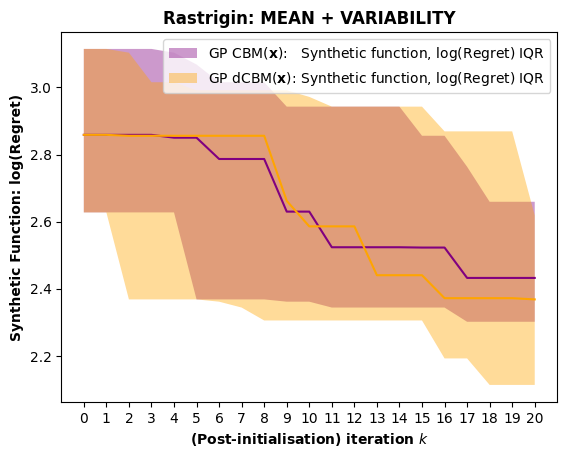

In [163]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(median_approx, color = 'Purple')
plt.plot(median_exact, color = 'Orange')

xstar = np.arange(0, max_iter+1, step=1)
plt.fill_between(xstar, lower_approx, upper_approx, facecolor = 'Purple', alpha=0.4, label='GP CBM($\mathbf{x}$):   Synthetic function, log(Regret) IQR')
plt.fill_between(xstar, lower_exact, upper_exact, facecolor = 'Orange', alpha=0.4, label='GP dCBM($\mathbf{x}$): Synthetic function, log(Regret) IQR')

plt.title(title, weight = 'bold')
plt.xlabel('(Post-initialisation) iteration $\it{k}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: log(Regret)', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(0, count))
plt.show()


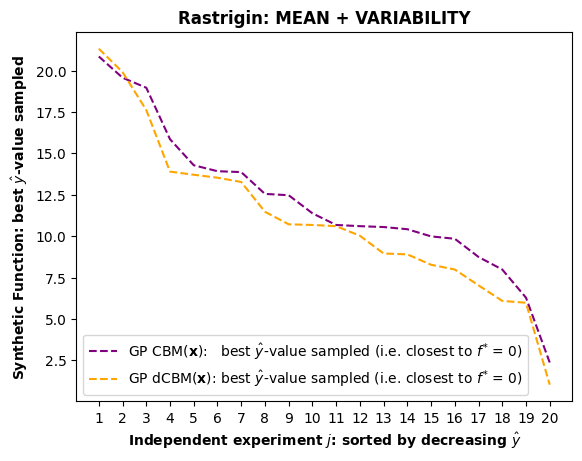

In [164]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.sort(approx_tau)[::-1], color = 'Purple', ls='--', label='GP CBM($\mathbf{x}$):   best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')
plt.plot(np.sort(exact_tau)[::-1], color = 'Orange', ls='--', label='GP dCBM($\mathbf{x}$): best $\it{\hat{y}}$-value sampled (i.e. closest to $\it{f^{*}}$ = 0)')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$: sorted by decreasing $\it{\hat{y}}$', weight = 'bold') # x-axis label
plt.ylabel('Synthetic Function: best $\it{\hat{y}}$-value sampled', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


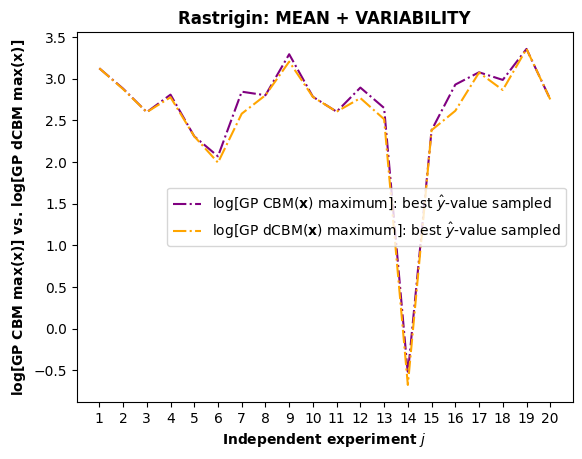

In [165]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(np.log(exact_acqFuncApproxBest), color = 'Purple', ls='-.', label='log[GP CBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')
plt.plot(np.log(exact_acqFuncExactBest), color = 'Orange', ls='-.', label='log[GP dCBM($\mathbf{x}$) maximum]: best $\it{\hat{y}}$-value sampled')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('log[GP CBM max($\mathbf{x}$)] vs. log[GP dCBM max($\mathbf{x}$)]', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


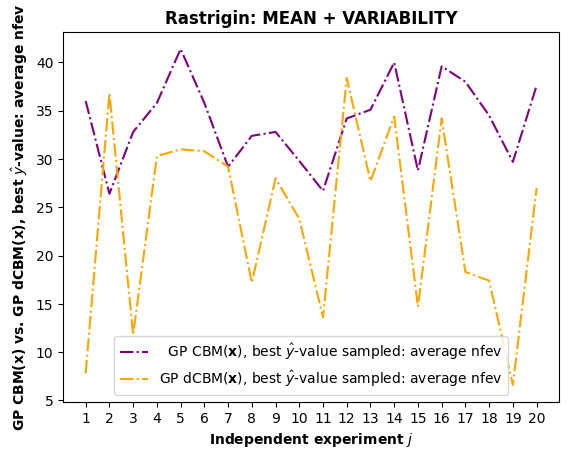

In [166]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_nfev_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')
plt.plot(exact_nfev_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value sampled: average nfev')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$), best $\it{\hat{y}}$-value: average nfev', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


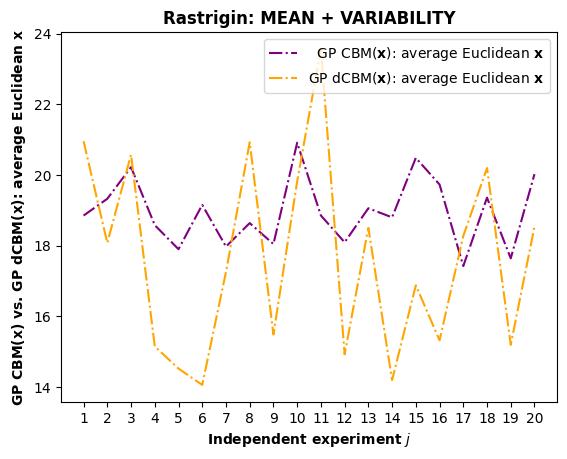

In [167]:
### Visualise!

cbm_both = ': MEAN + VARIABILITY'
title = obj_func + cbm_both

plt.figure()

plt.plot(approx_euclid_Avg, color = 'Purple', ls='-.', label='  GP CBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')
plt.plot(exact_euclid_Avg, color = 'Orange', ls='-.', label='GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$')

xstar = np.arange(0, max_iter, step=1)

plt.title(title, weight = 'bold')
plt.xlabel('Independent experiment $\it{j}$', weight = 'bold') # x-axis label
plt.ylabel('GP CBM($\mathbf{x}$) vs. GP dCBM($\mathbf{x}$): average Euclidean $\mathbf{x}$', weight = 'bold') # y-axis label
plt.legend(loc=0) # add plot legend

### Make the x-ticks integers, not floats:
count = len(xstar)
plt.xticks(np.arange(count), np.arange(1, count+1))
plt.show()


In [168]:
np.round(-approx_4.f_best, 4), np.max(np.round(-approx_4.f_best, 4)), approx_4.best


(array([ 3.8543, -0.575 ,  3.4638,  2.8086,  3.8543,  3.8543,  5.39  ,
         5.39  ,  1.6635, -5.0222,  4.8056,  5.39  ,  3.8543,  3.1455,
         4.8056,  2.8086,  5.39  , -1.1447,  5.39  ,  2.7343]),
 5.39,
 array([ 3.08112188, -3.1052826 ]))

In [169]:
np.round(-approx_4.f_best2, 4), np.max(np.round(-approx_4.f_best2, 4)), approx_4.best2


(array([-1.2515, -0.9464,  3.0368,  1.3875,  0.689 ,  3.4494,  3.6262,
         1.3875,  4.6842,  4.1436,  4.4797,  4.8372,  1.3875, -1.1919,
         4.0544,  2.8003, -0.5258,  2.4014,  0.2683,  1.3875]),
 4.8372,
 array([ 2.79030273, -2.74216362]))

In [170]:
np.round(approx_4.x_best, 4)


array([[ 1.4285,  1.3807],
       [-5.12  , -3.2329],
       [ 5.12  ,  3.9478],
       [ 2.1554,  4.2066],
       [ 1.4285,  1.3807],
       [ 1.4285,  1.3807],
       [ 3.0811, -3.1053],
       [ 3.0811, -3.1053],
       [-2.6975,  1.0944],
       [ 5.12  , -0.9261],
       [-0.1291,  3.1502],
       [ 3.0811, -3.1053],
       [ 1.4285,  1.3807],
       [-5.12  , -0.4045],
       [-0.1291,  3.1502],
       [ 2.1554,  4.2066],
       [ 3.0811, -3.1053],
       [ 3.1627, -5.12  ],
       [ 3.0811, -3.1053],
       [ 2.1342,  5.12  ]])

In [171]:
np.round(approx_4.x_best2, 4)


array([[-1.0483,  0.0084],
       [-4.9724, -3.2495],
       [ 0.9808,  2.1111],
       [ 5.12  ,  5.12  ],
       [-1.3481,  3.7693],
       [ 1.8391,  1.2986],
       [ 1.2262,  1.5817],
       [ 5.12  ,  5.12  ],
       [-0.4765,  3.2686],
       [-0.8046,  3.4074],
       [ 0.4112,  2.9181],
       [ 2.7903, -2.7422],
       [ 5.12  ,  5.12  ],
       [-3.6111, -0.3492],
       [ 0.6124,  2.7594],
       [ 2.1813,  4.1501],
       [ 3.4655, -4.5043],
       [-3.1953, -5.12  ],
       [ 0.9885, -2.5232],
       [ 5.12  ,  5.12  ]])

In [172]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best)**2))


15.851389806041734

In [173]:
np.sqrt(np.sum((approx_4.start_points_arr - approx_4.x_best2)**2))

19.476245062490822